In [1]:
%load_ext autoreload
%autoreload 2
#from gaia import *
import glob, os

import copy

import numpy as np
import IPython
from ipywidgets import *
import tkinter as tk
from tkinter import filedialog
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
import keras
print(keras.__version__)
print(tf.__version__)

from keras.layers import Input, Reshape, Dense, Activation
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils import multi_gpu_model 
import keras.losses
from keras.engine.topology import Layer

from IPython.display import HTML
from itertools import chain
import random

import matplotlib.ticker as ticker

#from mpl_toolkits.mplot3d import Axes3D
import pickle
import re

#%matplotlib notebook
#%matplotlib notebook 
%matplotlib inline
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import matplotlib.tri as tri
font = {'size'   : 21}
matplotlib.rc('font', **font)
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation

import time

from joblib import dump, load, Parallel, delayed
import gc
from plstm import PhasedLSTM
#from scipy import interpolate

Using TensorFlow backend.


2.3.1
1.14.0


In [2]:
pathSave = "/zeus/zeususer/agar_si/gaia/python/Compressed_Forward_Mars/"

In [ ]:
class Regression:
    def __init__(self,_data, _pathSave):
        self.x_test = _data.x_test
        self.y_test = _data.y_test
        self.yMin = _data.yMin
        self.yMax = _data.yMax
        self.xMin = _data.xMin
        self.xMax = _data.xMax
        self.xCoords = _data.x
        self.yCoords = _data.y
        self.pathSave = _pathSave
        
        self.ConvNN_x_test = np.zeros((_data.x_test.shape[0],_data.x_test.shape[1],_data.x_test.shape[1],1))
        
        for i in range(self.x_test.shape[0]):
            for j in range(self.x_test.shape[1]):
                self.ConvNN_x_test[i,j,j,:] = self.x_test[i,j]
        
        print("Test data: " + str(self.x_test.shape) + "," + str(self.y_test.shape))
        tf.keras.backend.clear_session()
        
    def ConvNN(self, _hSize, _NEPOCH, _learnRate, _mpDictTrain={}, _mpDictTest={}):
        graph = tf.get_default_graph()
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
        config = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        allow_soft_placement=True)

        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.8

        
        ae = ['T_Mars300_sims10k_f5A7s2_c3to24_tanh_l2reg_wlrsc', "conv2d_6", 840, [5,7,24], -11]
        nameNN = _hSize[0]
        nameAE = ae[0]
        
        session1 = tf.Session(config=config)
        session2 = tf.Session(config=config)
        with session1.as_default():
            with session1.graph.as_default():
                #model.compile(optimizer=keras.optimizers.Adam(), loss='mse') #lr=_learnRate, amsgrad=True
                ConvNN = load_model(self.pathSave + 'TrainedNetworks/ConvNN/' + nameNN +'.hdf5', \
                                custom_objects={'root_mean_squared_error': root_mean_squared_error})
                ConvNN.summary()

                checkDataML = ConvNN.predict(self.ConvNN_x_test)*(self.yMax-self.yMin) + self.yMin
                
        with session2.as_default():
            with session2.graph.as_default():
                autoencoder = load_model(self.pathSave + '/TrainedNetworks/autoencoder/' + nameAE + '.hdf5', \
                                         custom_objects={'root_mean_squared_error': root_mean_squared_error})
                autoencoder.summary()
                encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(ae[1]).output)
                encoded_input = Input(shape=(ae[3][0],ae[3][1],ae[3][2]))
                deco = encoded_input
                for l in range(ae[4],0):
                    deco = autoencoder.layers[l](deco)
                decoder = Model(encoded_input, deco)

                checkDataML = decoder.predict(checkDataML)         
                checkData = decoder.predict(self.y_test*(self.yMax-self.yMin) + self.yMin)
                
                
        print(checkData.shape)
        
        plotHistory=False
        if plotHistory:
            with open(self.pathSave + 'TrainedNetworks/NN/History_sims10k_f5s3_c369_tanh_' + str(_hSize) + '.txt', "rb") as myFile:
                history = pickle.load(myFile)   
            plt.figure(figsize=(24,12))
            plt.plot(history['loss'], 'k-')
            plt.plot(history['val_loss'], 'r-')
            plt.legend(['train', 'val'])
            plt.yscale('log')
            plt.xscale('log')
            plt.show()

        
        numLevels=32
        v_max=1.2
        v_min=0.2
        levels=np.linspace(v_min,v_max,numLevels)
        
        v_max_e=0.1
        v_min_e=-0.1
        levels_e=np.linspace(v_min_e,v_max_e,numLevels)
        
        cmapName = 'inferno'
        
        x_ = self.xCoords
        y_ = self.yCoords 
        min_radius = x_[0]
        triang = tri.Triangulation(x_, y_)
        triang.set_mask(np.hypot(x_[triang.triangles].mean(axis=1),y_[triang.triangles].mean(axis=1))< min_radius)

        displayPlots = 10
        plotEvery = int(checkData.shape[0]/displayPlots)
        predError = []
        predError2D = []
        predError2D_fReconst = []
        reconst_error = []

        saveGifPics = True
        if saveGifPics:
            x_orig_indices = []
            timeVec = []
            tol = 1e-6
            ra = self.x_test[13389,1]
            for i in range(self.y_test.shape[0]):
                if self.x_test[i,1] <= ra + tol and self.x_test[i,1] >= ra - tol :
                    x_orig_indices.append(i)
                    timeVec.append(self.x_test[i,0])
            sorted_indices = [x for _,x in sorted(zip(timeVec,x_orig_indices))]  #sort x using y
            x = np.zeros((1,6))
            x[0,:] = self.x_test[sorted_indices[0],:]

            fig = plt.figure(figsize=(3,3))
            ax = fig.add_subplot(1,1,1)                  
            ax.set_title('GAIA')

            def update(i):                      
                z = checkData[i,:,:,0].flatten()
                contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                ax.set_xlabel(self.x_test[i,0])
                return contg

            makeGaia_AE=False

            if makeGaia_AE:
                anim = FuncAnimation(fig, update, frames=sorted_indices)
                anim.save(self.pathSave + "/Gifs/ConvNN/GAIA_" + str(x) + str(_hSize) + '.gif', dpi=320, writer='imagemagick')

            fig = plt.figure(figsize=(3,3))
            ax = fig.add_subplot(1,1,1)                  
            ax.set_title('ML')

            def update(i):
                x[0,0] = self.x_test[i,0]                        
                z = checkDataML[i,:,:,0].flatten()
                contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                ax.set_xlabel(self.x_test[i,0])
                return contg

            anim = FuncAnimation(fig, update, frames=sorted_indices)
            anim.save(self.pathSave + "/Gifs/ConvNN/ML_" + str(x) + str(_hSize) + '.gif', dpi=320, writer='imagemagick')

        makePlots = True
        if makePlots:
            for it in range(checkData.shape[0]):
                Tactual = np.mean(checkData[it,:,:,0],axis=1)
                TML = np.mean(checkDataML[it,:,:,0],axis=1)
                predError.append(np.abs((Tactual*2000+250)-(TML*2000+250))/(Tactual*2000+250)*100)
                predError2D.append(np.abs((checkData[it,:,:,0]*2000+250)-(checkDataML[it,:,:,0]*2000+250))/(checkData[it,:,:,0]*2000+250)*100)
                
                if it%plotEvery==0:
                    print(it)
                    act = checkData[it,:,:,0].flatten()
                    pred = checkDataML[it,:,:,0].flatten()
                    fig = plt.figure(figsize=(24,14), dpi=320)
                    ax = fig.add_subplot(2,3,1) 
                    cax = ax.tricontourf(triang, act, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                    ax.set_title('T Actual')
                    fig.colorbar(cax, ax=ax)
                    ax = fig.add_subplot(2,3,2)
                    cax = ax.tricontourf(triang, pred, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                    ax.set_title('T Compressed')
                    fig.colorbar(cax, ax=ax)        
                    ax = fig.add_subplot(2,3,3)
                    rprof = np.linspace(0,1,checkDataML.shape[1])
                    ax.plot(Tactual,rprof,'k-')
                    ax.plot(TML,rprof,'b--')
                    plotRes = False

                    ax = fig.add_subplot(2,3,4) 
                    z1 = (checkData[it,:,:,0]-np.mean(checkData[it,:,:,0],axis=1,keepdims=True)).flatten()
                    cax = ax.tricontourf(triang, z1, extend="both", vmax=v_max_e, vmin=v_min_e, levels=levels_e, cmap=cmapName)
                    ax.set_title('T GAIA - Tmean')
                    fig.colorbar(cax, ax=ax)
                    ax = fig.add_subplot(2,3,5) 
                    z2 = (checkDataML[it,:,:,0]-np.mean(checkDataML[it,:,:,0],axis=1,keepdims=True)).flatten()
                    cax = ax.tricontourf(triang, z2, extend="both", vmax=v_max_e, vmin=v_min_e, levels=levels_e, cmap=cmapName)
                    ax.set_title('T NN - Tmean')
                    fig.colorbar(cax, ax=ax)
                    ax = fig.add_subplot(2,3,6) 
                    z = np.abs(z1-z2)
                    cax = ax.tricontourf(triang, z, numLevels, cmap=cmapName)
                    ax.set_title('|T reconst - Tmean - (T NN - Tmean)|')
                    fig.colorbar(cax, ax=ax)

            print('Average relative prediction error in T profiles: ' + str(np.mean(np.asarray(predError))))
            print('Average relative prediction error in T fields wrt GAIA: ' + str(np.mean(np.asarray(predError2D))))

        plt.show()
        
        return self 

In [ ]:
runThisCell=False
if runThisCell:
    nnDict = {}
    counter = 0
    
    dictToOpen = "processedDicts/Mars_new/ConvNN/T/Dict_processed_data_MarsNew_2D_ConvNN_T_[12000]sims_1channel_x_test.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data_test = load(myFile)
    dictToOpen = "processedDicts/Mars_new/ConvNN/T/Dict_processed_data_MarsNew_2D_ConvNN_T_[12000]sims_1channel.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)

    nnDict["Architecture" + str(counter)] = ['T_Mars300_sims10k_f5s3A2_c36912_Even_deeper_tanh_wlrsc']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['T_Mars300_sims10k_f5s3A2_c36912_deeper_tanh_wlrsc']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['T_Mars300_sims10k_f5s3A2_c36912_tanh_wlrsc']
    counter += 1

    resultsDict = {}
    for i in range(0,counter):

        class createData():
            pass
        data = createData()
        data.x_test = Dict_processed_data_test[0]
        data.y_test = Dict_processed_data_test[1]
        data.x = Dict_processed_data['x'] 
        data.y = Dict_processed_data['y'] 
        data.yMin = Dict_processed_data['postEncodedOMin'] 
        data.yMax = Dict_processed_data['postEncodedOMax']
        data.xMin = Dict_processed_data['paraMin'] 
        data.xMax = Dict_processed_data['paraMax']

        R1 = Regression(data, pathSave)
        results = R1.ConvNN(nnDict["Architecture" + str(i)], 5, 0.00001)

In [ ]:
class RegressionNN_wMelt:
    def __init__(self,_data, _pathSave):
        self.x_test = _data.x_test
        self.y_test = _data.y_test
        #self.yMin = _data.yMin
        #self.yMax = _data.yMax
        self.xMin = _data.xMin
        self.xMax = _data.xMax
        self.xCoords = _data.x
        self.yCoords = _data.y
        self.pathSave = _pathSave
        
        print("Test data: " + str(self.x_test.shape) + "," + str(self.y_test.shape))
        tf.keras.backend.clear_session()
        
    def NN(self, _hSize, _NEPOCH, _learnRate, _mpDictTrain={}, _mpDictTest={}):
        graph = tf.get_default_graph()
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
        def spatial_loss(y_true, y_pred):
            loss = 0
            for i in range(y_pred.shape[1]):
                loss += K.mean(K.square((y_pred[:,i,:,:] - y_true[:,i,:,:])* float(i+1)/float(5)), axis=-1) 
            return loss
        
        def LEB_loss(layer1,layer2,layer3):
            def loss(y_true, y_pred):
                l_i = K.expand_dims(layer1, 1)
                l_j = K.expand_dims(layer1, 2)
                l_i_2 = K.expand_dims(layer2, 1)
                l_j_2 = K.expand_dims(layer2, 2)
                l_i_3 = K.expand_dims(layer3, 1)
                l_j_3 = K.expand_dims(layer3, 2)
                return K.mean(K.square(y_pred - y_true), axis=-1) + \
                       K.mean(K.exp(-0.5/(layer1.shape[1].value*1e-3)*K.sum(tf.norm(l_i-l_j)))) + \
                       K.mean(K.exp(-0.5/(layer1.shape[1].value*1e-3)*K.sum(tf.norm(l_i_2-l_j_2)))) +\
                       K.mean(K.exp(-0.5/(layer1.shape[1].value*1e-3)*K.sum(tf.norm(l_i_3-l_j_3))))
            return loss
        
        #keras.losses.custom_loss = LEB_loss
        
        def custom_activation(x):
            return (tf.sin(x))
        
        config = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        allow_soft_placement=True)

        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.8

        
        ae = ['T_Mars300_sims10k_7600', "conv2d_4", 7600, [19,25,16], -7, 5]
        ae = ['T_Mars300_sims10k_f5A7s2_c3to24_tanh_l2reg_wlrsc', "conv2d_6", 840, [5,7,24], -11]
        ae = ['T_Mars300_sims10k_f7A11s3_c369_tanh_l2reg_wlrsc', "conv2d_3", 1620, [12,15,9], -7]
        nameNN = _hSize[0]
        nameAE = ae[0]
        
        session1 = tf.Session(config=config)
        session2 = tf.Session(config=config)
        with session1.as_default():
            with session1.graph.as_default():
                #model.compile(optimizer=keras.optimizers.Adam(), loss='mse') #lr=_learnRate, amsgrad=True
                NN = load_model(self.pathSave + 'TrainedNetworks/NN/' + nameNN +'.hdf5', \
                                custom_objects={'custom_activation': Activation(custom_activation), \
                                                'spatial_loss': spatial_loss, \
                                                'root_mean_squared_error': root_mean_squared_error, \
                                                'loss': root_mean_squared_error})
                NN.summary()
                
                checkDataML = NN.predict(self.x_test) #*(self.yMax-self.yMin) + self.yMin
                
        with session2.as_default():
            with session2.graph.as_default():
                autoencoder = load_model(self.pathSave + '/TrainedNetworks/autoencoder/' + nameAE + '.hdf5', \
                                         custom_objects={'root_mean_squared_error': root_mean_squared_error})
                autoencoder.summary()
                encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(ae[1]).output)
                encoded_input = Input(shape=(ae[3][0],ae[3][1],ae[3][2]))
                deco = encoded_input
                for l in range(ae[4],0):
                    deco = autoencoder.layers[l](deco)
                decoder = Model(encoded_input, deco)
                
                checkData = self.y_test #*(self.yMax-self.yMin) + self.yMin
                
                print(checkData.shape)

                plotHistory=False
                if plotHistory:
                    with open(self.pathSave + 'TrainedNetworks/NN/History_sims10k_f5s3_c369_tanh_' + str(_hSize) + '.txt', "rb") as myFile:
                        history = pickle.load(myFile)   
                    plt.figure(figsize=(24,12))
                    plt.plot(history['loss'], 'k-')
                    plt.plot(history['val_loss'], 'r-')
                    plt.legend(('train', 'val'))
                    plt.yscale('log')
                    plt.xscale('log')
                    plt.show()


                numLevels=32
                v_max=1.2
                v_min=0.2
                levels=np.linspace(v_min,v_max,numLevels)

                v_max_e=0.1
                v_min_e=-0.1
                levels_e=np.linspace(v_min_e,v_max_e,numLevels)

                cmapName = 'inferno'

                x_ = self.xCoords
                y_ = self.yCoords 
                min_radius = x_[0]
                triang = tri.Triangulation(x_, y_)
                triang.set_mask(np.hypot(x_[triang.triangles].mean(axis=1),y_[triang.triangles].mean(axis=1))< min_radius)

                displayPlots = 10
                plotEvery = int(checkData.shape[0]/displayPlots)
                predError = []
                predError2D = []
                predError2D_fReconst = []
                reconst_error = []

                saveGifPics = True
                if saveGifPics:
                    for indInterest in range(10):
                        x_orig_indices = []
                        timeVec = []
                        tol = 1e-6
                        #[0.56335504 0.07343849 0.85274351 0.94463797 0.91168234]
                        ra = self.x_test[indInterest,2]
                        for i in range(self.y_test.shape[0]):
                            if self.x_test[i,2] == self.x_test[indInterest,2] and self.x_test[i,3] == self.x_test[indInterest,3] and self.x_test[i,4] == self.x_test[indInterest,4]: 
                                x_orig_indices.append(i)
                                timeVec.append(self.x_test[i,1])
                        sorted_indices = [x for _,x in sorted(zip(timeVec,x_orig_indices))]  #sort x using y
                        x = np.zeros((1,7))
                        x[0,:] = self.x_test[sorted_indices[0],:]
                        fig = plt.figure(figsize=(3,3))
                        ax = fig.add_subplot(1,1,1)                  
                        ax.set_title('GAIA')
                        
                        def POD(X,r):
                            U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
                            Ur = U[:,:r]
                            Sigmar = np.diag(Sigma[:r])
                            VTr = VT[:r,:]
                            return Ur, Sigmar, VTr
                        
                        xml = np.zeros((ae[3][0]*ae[3][1]*ae[3][2],len(sorted_indices)))
                        xtrue = np.copy(xml)
                        
                        for ind,val in enumerate(sorted_indices):
                            xtrue[:,ind] = checkData[val,:,:,:].flatten()
                            xml[:,ind] = checkDataML[val,:,:,:].flatten()
                            
                        modeNums = 60                       
                        Ur, Sigmar, VTr = POD(xtrue,modeNums)
                        Ur_ml, Sigmar_ml, VTr_ml = POD(xml,modeNums)
                        
                        plt.figure(figsize=(14,6))
                        plt.plot(Sigmar.diagonal(),'bo',label="True")
                        plt.plot(Sigmar_ml.diagonal(),'rx',label="ML")
                        plt.legend()
                        plt.yscale("log")
                        plt.show()

                        def update(i): 
                            checkthis = checkData[i,2:]#,:,:]
                            checkthis.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                            z = decoder.predict(checkthis).flatten()
                            contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_xlabel(self.x_test[i,0])
                            return contg

                        makeGaia_AE=False
                        makeML = False
                        if makeGaia_AE:
                            anim = FuncAnimation(fig, update, frames=sorted_indices)
                            anim.save(self.pathSave + "/Gifs/NN/GAIA_" + str(x[0]) + '.gif', dpi=320, writer='imagemagick')

                        fig = plt.figure(figsize=(3,3))
                        ax = fig.add_subplot(1,1,1)                  
                        ax.set_title('ML')

                        def update(i):
                            x[0,0] = self.x_test[i,0]
                            checkthis = checkDataML[i,2:2+ae[2]] #,:,:]
                            checkthis.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                            z = decoder.predict(checkthis).flatten()
                            contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_xlabel(self.x_test[i,0])
                            return contg

                        if makeML:
                            anim = FuncAnimation(fig, update, frames=sorted_indices)
                            anim.save(self.pathSave + "/Gifs/NN/ML_" + str(x[0]) + str(_hSize) + '.gif', dpi=320, writer='imagemagick')

                makePlots = False
                if makePlots:
                    checkData = decoder.predict(checkData)
                    checkDataML = decoder.predict(checkDataML)
                    for it in range(checkData.shape[0]):
                        checkthis = checkData[it:it+1,:,:,:]
                        #checkthis.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                        #checkthis = decoder.predict(checkthis)
                        
                        checkthisML = checkDataML[it:it+1,:,:,:]
                        #checkthisML.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                        #checkthisML = decoder.predict(checkthisML)
                        
                        Tactual = np.mean(checkthis,axis=2)[0,:,0]
                        TML = np.mean(checkthisML,axis=2)[0,:,0]
                        predError.append(np.abs((Tactual*2000+250)-(TML*2000+250))/(Tactual*2000+250)*100)
                        predError2D.append(np.abs((checkData[it,:,:,0]*2000+250)-(checkDataML[it,:,:,0]*2000+250))/(checkData[it,:,:,0]*2000+250)*100)

                        if it%plotEvery==0:
                            print(it)
                            act = checkthis.flatten()
                            pred = checkthisML.flatten()
                            fig = plt.figure(figsize=(24,14), dpi=320)
                            ax = fig.add_subplot(2,3,1) 
                            cax = ax.tricontourf(triang, act, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_title('T Actual')
                            fig.colorbar(cax, ax=ax)
                            ax = fig.add_subplot(2,3,2)
                            cax = ax.tricontourf(triang, pred, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_title('T Compressed')
                            fig.colorbar(cax, ax=ax)        
                            ax = fig.add_subplot(2,3,3)
                            rprof = np.linspace(0,1,302)
                            ax.plot(Tactual,rprof,'k-')
                            ax.plot(TML,rprof,'b--')
                            plotRes = False

                            ax = fig.add_subplot(2,3,4) 
                            z1 = (checkthis-np.mean(checkthis,axis=1,keepdims=True)).flatten()
                            cax = ax.tricontourf(triang, z1, extend="both", vmax=v_max_e, vmin=v_min_e, levels=levels_e, cmap=cmapName)
                            ax.set_title('T GAIA - Tmean')
                            fig.colorbar(cax, ax=ax)
                            ax = fig.add_subplot(2,3,5) 
                            z2 = (checkthisML-np.mean(checkthisML,axis=1,keepdims=True)).flatten()
                            cax = ax.tricontourf(triang, z2, extend="both", vmax=v_max_e, vmin=v_min_e, levels=levels_e, cmap=cmapName)
                            ax.set_title('T NN - Tmean')
                            fig.colorbar(cax, ax=ax)
                            ax = fig.add_subplot(2,3,6) 
                            z = np.abs(z1-z2)
                            cax = ax.tricontourf(triang, z, numLevels, cmap=cmapName)
                            ax.set_title('|T reconst - Tmean - (T NN - Tmean)|')
                            fig.colorbar(cax, ax=ax)

                    print('Average relative prediction error in T profiles: ' + str(np.mean(np.asarray(predError))))
                    print('Average relative prediction error in T fields wrt GAIA: ' + str(np.mean(np.asarray(predError2D))))

                plt.show()
        
        return self 

In [ ]:
runCell=False

if runCell:
    ## NN parameters
    nnDict = {}
    counter = 0

    dictToOpen = "processedDicts/Mars_new/NN/T/Dict_processed_data_MarsNew_2D_NN_wMelt_T_[10000]sims_1channel_ae1620_x_test.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data_test = load(myFile)
    dictToOpen = "processedDicts/Mars_new/NN/T/Dict_processed_data_MarsNew_2D_NN_wMelt_T_[10000]sims_1channel_ae1620.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)

    nnDict["Architecture" + str(counter)] = ['T_Mars300_sims10k_ae1620_NN_wMelt_[200, 200, 200, 200, 200]_tanh']
    counter += 1

    class createData():
        pass
    data = createData()
    data.x_test = Dict_processed_data_test[0]
    data.y_test = Dict_processed_data_test[1]
    data.x = Dict_processed_data['x'] 
    data.y = Dict_processed_data['y'] 
    data.xMax = Dict_processed_data["xMax"]
    data.xMin = Dict_processed_data["xMin"]
    #data.yMax = Dict_processed_data["yMax"]
    #data.yMin = Dict_processed_data["yMin"]

    R1 = RegressionNN_wMelt(data, pathSave)

    resultsDict = {}
    for i in range(1):
        results = R1.NN(nnDict["Architecture" + str(i)], 5, 0.00001)

In [ ]:
class RegressionNN:
    def __init__(self,_data, _pathSave):
        self.yMin = _data.yMin
        self.yMax = _data.yMax
        self.xMin = _data.xMin
        self.xMax = _data.xMax
        self.xCoords = _data.x
        self.yCoords = _data.y
        self.pathSave = _pathSave
        
        self.x_test = np.zeros((data.x_test.shape[0],data.x_test.shape[1],6))
        self.y_test = np.zeros((data.x_test.shape[0],data.x_test.shape[1],5,7,24))
        
        counter = 0
        for simInd in range(data.x_test.shape[0]):
            for tInd in range(data.x_test.shape[1]):
                if data.x_test[simInd,tInd,0,0,0] > 0:
                    self.x_test[simInd,tInd,1:] = data.x_test[simInd,tInd,0,2:,0]
                    self.x_test[simInd,tInd,0] = data.x_test[simInd,tInd,1,0,0]
                    self.y_test[simInd,tInd,:,:,:] = data.x_test[simInd,tInd,:,:,1:].reshape(5,7,24)
                    counter += 1

        self.x_test[:,:,0] = ((self.x_test[:,:,0]*(data.xMax_lstm[0]-data.xMin_lstm[0])+data.xMin_lstm[0])-self.xMin[0])/(self.xMax[0]-self.xMin[0])
        for i in range(1,6):
            self.x_test[:,:,i] = ((self.x_test[:,:,i]*(data.xMax_lstm[i+2]-data.xMin_lstm[i+2])+data.xMin_lstm[i+2])-self.xMin[i])/(self.xMax[i]-self.xMin[i])
        
        
        dictToOpen = "processedDicts/Mars_new/T/Dict_NewMars_preProcessed_" + str([12000]) + "sims_0.9trPercent.txt"
        with open(self.pathSave + dictToOpen, "rb") as myFile:
            Dict_processed_data_monly = load(myFile)
        
        self.oMax = Dict_processed_data_monly['pMax']
        self.oMin = Dict_processed_data_monly['pMin']

        self.take_indices = [0,2,12,17,19] #np.arange(self.x_test.shape[0]) #
        self.gaia_indices =[11345, 11346, 11347, 11348, 11349, 11351, 11353, 11354, 11355, 11357, 11358, 11359, 11360, 11361, 
                            11362, 11363, 11364, 11366, 11367, 11368, 11371, 11372, 11373, 11374, 11377, 11378, 11379, 11381, 11383, 11385, 
                            11386, 11387, 11388, 11390, 11391, 11392, 11393, 11394, 11395, 11396, 11397, 11398, 11399, 11400, 11401, 11402, 
                            11403, 11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11417, 11418, 11419, 11420, 
                            11421, 11422, 11423, 11424, 11425, 11426, 11427, 11429, 11430, 11431, 11432, 11433, 11434, 11435, 11436, 11437, 
                            11438, 11439, 11440, 11441, 11443, 11444, 11445, 11446, 11447, 11448, 11449, 11451, 11452, 11454, 11455, 11456, 
                            11457, 11458
                           ]
        
        print("Test data: " + str(self.x_test.shape) + "," + str(self.y_test.shape))
        tf.keras.backend.clear_session()
        
    def NN(self, _hSize, _NEPOCH, _learnRate, _mpDictTrain={}, _mpDictTest={}):
        graph = tf.get_default_graph()
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
        def spatial_loss(y_true, y_pred):
            loss = 0
            for i in range(y_pred.shape[1]):
                loss += K.mean(K.square((y_pred[:,i,:,:] - y_true[:,i,:,:])* float(i+1)/float(5)), axis=-1) 
            return loss
        
        def LEB_loss(layer1,layer2,layer3):
            def loss(y_true, y_pred):
                l_i = K.expand_dims(layer1, 1)
                l_j = K.expand_dims(layer1, 2)
                l_i_2 = K.expand_dims(layer2, 1)
                l_j_2 = K.expand_dims(layer2, 2)
                l_i_3 = K.expand_dims(layer3, 1)
                l_j_3 = K.expand_dims(layer3, 2)
                return K.mean(K.square(y_pred - y_true), axis=-1) + \
                       K.mean(K.exp(-0.5/(layer1.shape[1].value*1e-3)*K.sum(tf.norm(l_i-l_j)))) + \
                       K.mean(K.exp(-0.5/(layer1.shape[1].value*1e-3)*K.sum(tf.norm(l_i_2-l_j_2)))) +\
                       K.mean(K.exp(-0.5/(layer1.shape[1].value*1e-3)*K.sum(tf.norm(l_i_3-l_j_3))))
            return loss
        
        #keras.losses.custom_loss = LEB_loss
        
        def custom_activation(x):
            return (tf.sin(x))
        
        config = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        allow_soft_placement=True)

        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.8

        
        #ae = ['T_Mars300_sims10k_7600', "conv2d_4", 7600, [19,25,16], -7, 5]
        ae = ['T_Mars300_sims10k_f5A7s2_c3to24_tanh_l2reg_wlrsc', "conv2d_6", 840, [5,7,24], -11]
        #ae = ['T_Mars300_sims10k_f7A11s3_c369', "conv2d_3", 1620, [12,15,9], -7]
        nameAE = ae[0]
        
        session1 = tf.Session(config=config)
        session2 = tf.Session(config=config)
        with session1.as_default():
            with session1.graph.as_default():
                #model.compile(optimizer=keras.optimizers.Adam(), loss='mse') #lr=_learnRate, amsgrad=True
                NN = load_model(self.pathSave + 'TrainedNetworks/NN/' + _hSize +'.hdf5', \
                                custom_objects={'custom_activation': Activation(custom_activation), \
                                                'spatial_loss': spatial_loss, \
                                                'root_mean_squared_error': root_mean_squared_error, \
                                                'loss': root_mean_squared_error})
                NN.summary()
                checkDataML = np.zeros((data.x_test.shape[0],data.x_test.shape[1],302,394,1))
                checkData = np.zeros((data.x_test.shape[0],data.x_test.shape[1],302,394,1))
                checkDataml = np.zeros((data.x_test.shape[0],data.x_test.shape[1],5,7,24))
                
                for simInd in range(data.x_test.shape[0]):
                    for tInd in range(data.x_test.shape[1]):
                        if data.x_test[simInd,tInd,0,0,0] > 0:
                            inp = self.x_test[simInd,tInd,:].reshape(1,6)
                            checkDataml[simInd,tInd,:,:,:] = (NN.predict(inp)*(self.yMax-self.yMin)+self.yMin).reshape(5,7,24)
                
        with session2.as_default():
            with session2.graph.as_default():
                autoencoder = load_model(self.pathSave + '/TrainedNetworks/autoencoder/' + nameAE + '.hdf5', \
                                         custom_objects={'root_mean_squared_error': root_mean_squared_error})
                autoencoder.summary()
                encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(ae[1]).output)
                encoded_input = Input(shape=(ae[3][0],ae[3][1],ae[3][2]))
                deco = encoded_input
                for l in range(ae[4],0):
                    deco = autoencoder.layers[l](deco)
                decoder = Model(encoded_input, deco)
                
                self.y_test = self.y_test*(self.yMax-self.yMin) + self.yMin
                
                print(checkData.shape)

                plotHistory=False
                if plotHistory:
                    with open(self.pathSave + 'TrainedNetworks/NN/History_sims10k_f5s3_c369_tanh_' + str(_hSize) + '.txt', "rb") as myFile:
                        history = pickle.load(myFile)   
                    plt.figure(figsize=(24,12))
                    plt.plot(history['loss'], 'k-')
                    plt.plot(history['val_loss'], 'r-')
                    plt.legend(['train', 'val'])
                    plt.yscale('log')
                    plt.xscale('log')
                    plt.show()


                numLevels=32
                v_max=1.2
                v_min=0.2
                levels=np.linspace(v_min,v_max,numLevels)

                v_max_e=0.1
                v_min_e=-0.1
                levels_e=np.linspace(v_min_e,v_max_e,numLevels)

                cmapName = 'inferno'

                x_ = self.xCoords
                y_ = self.yCoords 
                min_radius = x_[0]
                triang = tri.Triangulation(x_, y_)
                triang.set_mask(np.hypot(x_[triang.triangles].mean(axis=1),y_[triang.triangles].mean(axis=1))< min_radius)

                displayPlots = 10
                plotEvery = int(checkData.shape[0]/displayPlots)
                predError = []
                predError2D = []
                predError2D_fReconst = []
                reconst_error = []
                    
                for simInd in range(data.x_test.shape[0]):
                    for tInd in range(data.x_test.shape[1]):
                        if data.x_test[simInd,tInd,0,0,0] > 0:
                            checkDataML[simInd,tInd,:,:,:] = decoder.predict(checkDataml[simInd,tInd:tInd+1,:,:,:])*(self.oMax-self.oMin)+self.oMin
                    
                            checkData[simInd,tInd,:,:,:] = decoder.predict(self.y_test[simInd,tInd:tInd+1,:,:,:])*(self.oMax-self.oMin)+self.oMin
                  
                with open(pathSave + "Results/NN_" + _hSize + "_" + str(len(self.take_indices)) + "_Compressed.txt", "wb") as f:
                    dump(checkDataml , f, protocol=4) 
                with open(pathSave + "Results/NN_" + _hSize + "_" + str(len(self.take_indices)) + ".txt", "wb") as f:
                    dump(checkDataML , f, protocol=4) 
                    
                saveGifPics = False                        
                if saveGifPics:
                    makeGaia_AE=False
                    makeML = False
                    makePlots = False
                    makePOD = False
                    gaia_ind = 0
                    for sim_ind in range(data.x_test.shape[0]):
                        ra = data.x_test[sim_ind,0,0,2,0]
                        Eref = data.x_test[sim_ind,0,0,3,0]
                        x_orig_indices = []
                        timeVec = []
                        tol = 1e-2
                        #[0.56335504 0.07343849 0.85274351 0.94463797 0.91168234]
                        #0. 0.55624625 0.11810412 0.16827946 0.60985078 0.63092619].gif
                        #ra = 0.30405844 #0.55624625 #0.30405844 #self.x_test[indInterest,1]
                        for i in range(self.y_test.shape[0]):
                            if self.x_test[i,1] >= ra-tol and self.x_test[i,1] <= ra+tol \
                            and self.x_test[i,2] >= Eref-tol and self.x_test[i,2] <= Eref+tol:
                                x_orig_indices.append(i)
                                timeVec.append(self.x_test[i,0])
                        sorted_indices = [x for _,x in sorted(zip(timeVec,x_orig_indices))]  #sort x using y
                        x = np.zeros((1,6))
                        x[0,:] = self.x_test[sorted_indices[0],:]
                                                
                        def POD(X,r):
                            U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
                            Ur = U[:,:r]
                            Sigmar = np.diag(Sigma[:r])
                            VTr = VT[:r,:]
                            return Ur, Sigmar, VTr
                        
                        if makePOD:
                            xml = np.zeros((302*394,len(sorted_indices)))
                            xtrue = np.copy(xml)

                            for ind,val in enumerate(sorted_indices):
                                xtrue[:,ind] = checkData[val:val+1,:,:,:].flatten()
                                xml[:,ind] = checkDataML[val:val+1,:,:,:].flatten()

                            modeNums = 100                       
                            Ur, Sigmar, VTr = POD(xtrue,modeNums)
                            Ur_ml, Sigmar_ml, VTr_ml = POD(xml,modeNums)

                            plt.figure(figsize=(14,6))
                            plt.plot(Sigmar.diagonal(),'bo',label="True")
                            plt.plot(Sigmar_ml.diagonal(),'rx',label="ML")
                            plt.legend()
                            plt.yscale("log")
                            plt.ylabel("Eigenfrequency")
                            plt.xlabel("Mode")
                            plt.show()

                            coeff = Ur.T @ xtrue

                            for i in range(4):
                                plt.figure()
                                plt.plot(coeff[i,:],'b-')                            

                                fig = plt.figure(figsize=(14,6))
                                ax = fig.add_subplot(1,2,1) 
                                ax.plot(Ur[:,i].flatten(),Ur_ml[:,i].flatten(),'b.')

                                ax = fig.add_subplot(1,2,2) 
                                ax.plot(VTr[i,:].flatten(),VTr_ml[i,:].flatten(),'r.')

                                plt.show()

                            
                        fig = plt.figure(figsize=(3,3))
                        ax = fig.add_subplot(1,1,1)                  
                        ax.set_title('GAIA')
                        
                        def update(i): 
                            z = checkData[i,:,:,:].flatten()
                            #z.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                            #z = decoder.predict(checkthis).flatten()*(self.oMax-self.oMin)+self.oMin
                            contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_xlabel(self.x_test[i,0])
                            return contg

                        if makeGaia_AE:
                            anim = FuncAnimation(fig, update, frames=sorted_indices)
                            anim.save(self.pathSave + "/Gifs/NN/GAIA_" + str(sim_ind) + '.gif', dpi=200, writer='imagemagick')

                        if makeML:
                            fig = plt.figure(figsize=(4,4))
                            ax = fig.add_subplot(1,1,1)                  
                            ax.set_title('LSTM')
                            def update(i):                      
                                z = checkDataML[simInd,i,:,:,:].flatten()
                                contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                                ax.set_xlabel("$t_{" + str(i) + "} = " + str(np.round((self.x_test[simInd,i,1,0,0]*(self.xMax[0]-self.xMin[0])+self.xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9),1)) + "$ Gyr")
                                return contg

                            anim = FuncAnimation(fig, update, frames=np.arange(nonZero))
                            plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
                            anim.save(self.pathSave + "/Gifs/LSTM/ML_" + str(_hSize) + "_" + str(simInd) + '.gif', dpi=200, writer='imagemagick')
                        
                        D = 1700e+3 
                        k_diffusive = 1e-6    
                        year_to_seconds = 365.25 * 24. * 3600.
                        tol = 1e-1
                        
                        
                        if makePlots:                            
                            for ind, it in enumerate(sorted_indices):
                                time = (self.x_test[it,0]*(self.xMax[0]-self.xMin[0])+self.xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9)

                                ml = checkDataML[it,:,:,:]
                                #ml.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                                #ml = decoder.predict(ml)*(self.oMax-self.oMin)+self.oMin

                                convae = checkData[it,:,:,:]
                                #convae.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                                #convae = decoder.predict(convae)*(self.oMax-self.oMin)+self.oMin
                                
                                gaia = checkDataGaia[gaia_ind,ind,:,:,:]

                                TConvAE = np.mean(convae,axis=2)[0,:,0]
                                TML = np.mean(ml,axis=2)[0,:,0]
                                TGAIA = np.mean(gaia,axis=1)
                                
                                if (time>=1-tol and time<=1+tol) or \
                                (time>=2-tol and time<=2+tol) or \
                                (time>=3-tol and time<=3+tol) or \
                                (time>=4.5-1e-5 and time<=4.5+1e-5):

                                    act = convae.flatten()
                                    pred = ml.flatten()
                                    predGaia = gaia.flatten()

                                    fig = plt.figure(figsize=(16,4), dpi=320)

                                    ax = fig.add_subplot(1,4,1) 
                                    cax = ax.tricontourf(triang, predGaia, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                                    ax.set_title('GAIA')
                                    ax.set_xlabel("Radius$'$")
                                    ax.set_ylabel("Radius$'$")
                                    ax.set_xticks([0.33,0.83,1.33])
                                    ax.set_yticks([0.33,0.83,1.33])
                                    #fig.colorbar(cax, ax=ax)

                                    ax = fig.add_subplot(1,4,2) 
                                    cax = ax.tricontourf(triang, act, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                                    ax.set_title('ConvAE')
                                    ax.set_xlabel("Radius$'$")
                                    ax.set_xticks([0.33,0.83,1.33])
                                    ax.set_yticks([0.33,0.83,1.33])
                                    #fig.colorbar(cax, ax=ax)

                                    ax = fig.add_subplot(1,4,3)
                                    cax = ax.tricontourf(triang, pred, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                                    ax.set_title('NN')
                                    ax.set_xlabel("Radius$'$")
                                    ax.set_xticks([0.33,0.83,1.33])
                                    ax.set_yticks([0.33,0.83,1.33])
                                    #fig.colorbar(cax, ax=ax)  

                                    ax = fig.add_subplot(1,4,4)
                                    rprof = np.linspace(0.33,1.33,302)
                                    ax.plot(TGAIA,rprof,'k-',linewidth=3)
                                    ax.plot(TConvAE,rprof,'b--',linewidth=3)
                                    ax.plot(TML,rprof,'r--',linewidth=3)
                                    ax.set_title(str(np.round(time,1))+ " Gyr")
                                    ax.set_xlabel("Temperature$'$")
                                    ax.set_yticks([0.33,0.83,1.33])                                    
                                    ax.legend(["GAIA", "ConvAE", "ML"])

                                    plt.tight_layout(pad=0.1)
                                    plt.show()
                        gaia_ind += 1
        return self 

In [ ]:
runCell=True

if runCell:
    ## NN parameters
    nnDict = {}
    counter = 0

    aeSize = 840
    
    class createData():
        pass
    data = createData()
    
    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_96sims_1channel_ae840_x_test_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        data.x_test = load(myFile)
        
    take_indices = [0,2,12,17,19]
    data.x_test = data.x_test[take_indices,:,:,:,:]
        
    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_[12000]sims_1channel_ae840_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)
    data.xMin_lstm = Dict_processed_data['paraMin'] 
    data.xMax_lstm = Dict_processed_data['paraMax']

    dictToOpen = "processedDicts/Mars_new/NN/T/Dict_processed_data_MarsNew_2D_NN_T_[12000]sims_1channel_ae" + str(aeSize) + "_0p9tr.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)
   
    nnList = ['NN_[1800, 1800, 1800, 1800]_selu_ae' + str(aeSize) + '_0p98tr',
              'NN_[1800, 1800, 1800]_selu_ae' + str(aeSize) + '_0p98tr',
              #'NN_[400, 400, 400, 400, 400, 400, 400, 400]_selu_ae' + str(aeSize) + '_0p9tr',
              'NN_[400, 400, 400, 400, 400, 400, 400, 400]_selu_ae' + str(aeSize) + '_0p98tr',
              'NN_[800, 800, 800, 800, 800]_selu_ae' + str(aeSize) + '_0p98tr',
              'ConvNN_[128, 128, 128, 128, 128, 128, 128, 128]_selu_ae' + str(aeSize) + '_0p98tr',
              'ConvNN_[256, 256, 256, 256, 256, 256]_selu_ae' + str(aeSize) + '_0p98tr',
              'ConvNN_[1024, 1024, 1024, 1024, 1024, 1024]_selu_ae' + str(aeSize) + '_0p98tr',
              'ConvNN_[2048, 2048, 2048, 2048]_selu_ae' + str(aeSize) + '_0p98tr']
    
    loss_nn = {}
    loss_nn_cv = {}
    for i, nn in enumerate(nnList):
        f = open(pathSave + 'TrainedNetworks/NN/' + nn + '.txt', 'r')
        lines = f.readlines()   
        l = []
        l_cv = []
        for _l in lines[1:]:
            l.append(float(_l.split(',')[1]))#-0.0002185941787383483)
            l_cv.append(float(_l.split(',')[2]))#-0.0002185941787383483)

        loss_nn[str(i)] = l
        loss_nn_cv[str(i)] = l_cv
        
    fig = plt.figure(figsize=(12,6), dpi=320)
    ax = fig.add_subplot(1,2,1) 
    axc = fig.add_subplot(1,2,2) 
    colors = ['r', 'b', 'm', 'y', 'k', 'g', 'c', 'brown']
    for i in range(len(nnList)):
        #ynew = interpolate.interp1d(np.arange(0,len(loss_cv[str(i)])), loss_cv[str(i)])
        ax.plot(loss_nn[str(i)], '-', label=nnList[i].split("_")[1])
        #axc.plot(ynew(np.arange(0,3)), colors[i]+'--',label=nnList[i].split("],")[0][2:]+"_tr")
        axc.plot(loss_nn_cv[str(i)], '--', label=nnList[i].split("_")[1])
    ax.set_yscale("log")
    ax.set_ylim([2e-4,1e-3])
    ax.legend(prop={'size': 11})
    ax.set_title("NN Training")
    axc.set_yscale("log")
    axc.set_ylim([2e-4,1e-3])
    axc.legend(prop={'size': 11})
    axc.set_title("NN Cross-validation")
    #ax.set_xticks([0,300,600,900])
    #axc.set_xticks([0,300,600,900])
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epochs")
    axc.set_xlabel("Epochs")
    plt.tight_layout()
    plt.show()
    fig.savefig(pathSave + "Results/Fig_NN_loss.pdf", bbox_inches='tight')

    data.x = Dict_processed_data['x'] 
    data.y = Dict_processed_data['y'] 
    data.xMax = Dict_processed_data["xMax"]
    data.xMin = Dict_processed_data["xMin"]
    data.yMax = Dict_processed_data["yMax"]
    data.yMin = Dict_processed_data["yMin"]
    
    def runArchitecture(nn):      
        print(nn)
        R1 = RegressionNN(data, pathSave)
        results = R1.NN(nn, 5, 0.00001)
        
    Parallel(n_jobs=1, verbose=10)(delayed(runArchitecture)(_nn) for _nn in nnList[2:3])

In [ ]:
class RegressionNN_pod:
    def __init__(self):
        
        tf.keras.backend.clear_session()
        
    def NN(self, data, _hSize, _NEPOCH, _learnRate, _mpDictTrain={}, _mpDictTest={}):
        graph = tf.get_default_graph()
        
        config = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        allow_soft_placement=True)

        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.8

        
        #ae = ['T_Mars300_sims10k_7600', "conv2d_4", 7600, [19,25,16], -7, 5]
        #ae = ['T_Mars300_sims10k_f5A7s2_c3to24_tanh_l2reg_wlrsc', "conv2d_6", 840, [5,7,24], -11]
        ae = ['T_Mars300_sims10k_f7A11s3_c369', "conv2d_3", 1620, [12,15,9], -7]
        nameNN = _hSize[0]
        nameAE = ae[0]
        
        session1 = tf.Session(config=config)
        session2 = tf.Session(config=config)
        with session1.as_default():
            with session1.graph.as_default():
                #model.compile(optimizer=keras.optimizers.Adam(), loss='mse') #lr=_learnRate, amsgrad=True
                NN = load_model(data.pathSave + 'TrainedNetworks/NN/' + nameNN +'.hdf5')
                NN.summary()
                
                checkDataML = NN.predict(data.x_test)
                checkData = np.copy(data.y_test)
                
        with session2.as_default():
            with session2.graph.as_default():
                autoencoder = load_model(data.pathSave + '/TrainedNetworks/autoencoder/' + nameAE + '.hdf5')
                autoencoder.summary()
                encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(ae[1]).output)
                encoded_input = Input(shape=(ae[3][0],ae[3][1],ae[3][2]))
                deco = encoded_input
                for l in range(ae[4],0):
                    deco = autoencoder.layers[l](deco)
                decoder = Model(encoded_input, deco)
                
                print(checkData.shape)

                plotHistory=False
                if plotHistory:
                    with open(data.pathSave + 'TrainedNetworks/NN/History_sims10k_f5s3_c369_tanh_' + str(_hSize) + '.txt', "rb") as myFile:
                        history = pickle.load(myFile)   
                    plt.figure(figsize=(24,12))
                    plt.plot(history['loss'], 'k-')
                    plt.plot(history['val_loss'], 'r-')
                    plt.legend(['train', 'val'])
                    plt.yscale('log')
                    plt.xscale('log')
                    plt.show()


                numLevels=32
                v_max=1.2
                v_min=0.2
                levels=np.linspace(v_min,v_max,numLevels)

                v_max_e=0.1
                v_min_e=-0.1
                levels_e=np.linspace(v_min_e,v_max_e,numLevels)

                cmapName = 'inferno'

                x_ = data.x
                y_ = data.y
                min_radius = x_[0]
                triang = tri.Triangulation(x_, y_)
                triang.set_mask(np.hypot(x_[triang.triangles].mean(axis=1),y_[triang.triangles].mean(axis=1))< min_radius)

                displayPlots = 10
                plotEvery = int(checkData.shape[0]/displayPlots)
                predError = []
                predError2D = []
                predError2D_fReconst = []
                reconst_error = []

                saveGifPics = True
                if saveGifPics:
                    for ra in [0.30405844, 0.55624625]:
                        x_orig_indices = []
                        timeVec = []
                        tol = 1e-6
                        #[0.56335504 0.07343849 0.85274351 0.94463797 0.91168234]
                        #0. 0.55624625 0.11810412 0.16827946 0.60985078 0.63092619].gif
                        #ra = 0.30405844 #0.55624625 #0.30405844 #data.x_test[indInterest,1]
                        for i in range(data.y_test.shape[0]):
                            if data.x_test[i,1] >= ra-tol and data.x_test[i,1] <= ra+tol:
                                x_orig_indices.append(i)
                                timeVec.append(data.x_test[i,0])
                        sorted_indices = [x for _,x in sorted(zip(timeVec,x_orig_indices))]  #sort x using y
                        x = np.zeros((1,6))
                        x[0,:] = data.x_test[sorted_indices[0],:]
                        
                        numModes = len(sorted_indices)
                        print(numModes)
                        Ur, Sigmar, VTr = np.zeros((ae[2],numModes)),  np.zeros((numModes,numModes)), np.zeros((numModes,numModes))
                        Ur_ml, Sigmar_ml, VTr_ml = np.zeros((ae[2],numModes)),  np.zeros((numModes,numModes)), np.zeros((numModes,numModes))
                        
                        doDimensionalize = True
                        for ind, i in enumerate(sorted_indices):            
                            Ur[:,ind], Sigmar[ind,ind], VTr[ind,:] = checkData[i,:ae[2]], checkData[i,ae[2]:ae[2]+1], checkData[i,ae[2]+1:]
                            Ur_ml[:,ind], Sigmar_ml[ind,ind], VTr_ml[ind,:] = checkDataML[i,:ae[2]], checkDataML[i,ae[2]:ae[2]+1], checkDataML[i,ae[2]+1:]
                        
                        if doDimensionalize:
                            Ur = Ur * (data.Ur_max-data.Ur_min) + data.Ur_min
                            Sigmar = np.power(10,Sigmar * (data.Sigmar_max-data.Sigmar_min) + data.Sigmar_min)
                            VTr = VTr * (data.VTr_max-data.VTr_min) + data.VTr_min

                            Ur_ml = Ur_ml * (data.Ur_max-data.Ur_min) + data.Ur_min
                            Sigmar_ml = np.power(10,Sigmar_ml * (data.Sigmar_max-data.Sigmar_min) + data.Sigmar_min)
                            VTr_ml = VTr_ml * (data.VTr_max-data.VTr_min) + data.VTr_min
                        
                        
                        plt.figure(figsize=(14,6))
                        plt.plot(Sigmar.diagonal(),'bo',label="True")
                        plt.plot(Sigmar_ml.diagonal(),'rx',label="ML")
                        plt.legend()
                        plt.yscale("log")
                        plt.show()
                        
                        for i in range(10):
                            fig = plt.figure(figsize=(14,6))
                            ax = fig.add_subplot(1,2,1) 
                            ax.plot(Ur[:,i].flatten(),Ur_ml[:,i].flatten(),'b.')
                            
                            ax = fig.add_subplot(1,2,2) 
                            ax.plot(VTr[i,:].flatten(),VTr_ml[i,:].flatten(),'r.')
                            
                            plt.show()
                                                
                        data.X_test = Ur @ Sigmar @ VTr
                        data.X_ml = Ur_ml @ Sigmar_ml @ VTr_ml
                        
                        fig = plt.figure(figsize=(3,3))
                        ax = fig.add_subplot(1,1,1)                  
                        ax.set_title('GAIA')
                        
                        def update(i): 
                            checkthis = data.X_test[:,i]
                            checkthis.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                            z = decoder.predict(checkthis).flatten()
                            contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_xlabel(data.x_test[i,0])
                            return contg

                        makeGaia_AE=False
                        makeML = False
                        if makeGaia_AE:
                            anim = FuncAnimation(fig, update, frames=np.arange(numModes))
                            anim.save(data.pathSave + "/Gifs/NN/podGAIA_" + str(x[0]) + '.gif', dpi=320, writer='imagemagick')

                        fig = plt.figure(figsize=(3,3))
                        ax = fig.add_subplot(1,1,1)                  
                        ax.set_title('ML')

                        def update(i):
                            x[0,0] = data.x_test[i,0]
                            checkthis = data.X_ml[:,i]
                            checkthis.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                            z = decoder.predict(checkthis).flatten()
                            contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_xlabel(data.x_test[i,0])
                            return contg

                        if makeML:
                            anim = FuncAnimation(fig, update, frames=np.arange(numModes))
                            anim.save(data.pathSave + "/Gifs/NN/podML_" + str(x[0]) + str(_hSize) + '.gif', dpi=320, writer='imagemagick')

                makePlots = False
                if makePlots:
                    checkData = decoder.predict(checkData)
                    checkDataML = decoder.predict(checkDataML)
                    for it in range(checkData.shape[0]):
                        checkthis = checkData[it:it+1,:,:,:]
                        #checkthis.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                        #checkthis = decoder.predict(checkthis)
                        
                        checkthisML = checkDataML[it:it+1,:,:,:]
                        #checkthisML.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                        #checkthisML = decoder.predict(checkthisML)
                        
                        Tactual = np.mean(checkthis,axis=2)[0,:,0]
                        TML = np.mean(checkthisML,axis=2)[0,:,0]
                        predError.append(np.abs((Tactual*2000+250)-(TML*2000+250))/(Tactual*2000+250)*100)
                        predError2D.append(np.abs((checkData[it,:,:,0]*2000+250)-(checkDataML[it,:,:,0]*2000+250))/(checkData[it,:,:,0]*2000+250)*100)

                        if it%plotEvery==0:
                            print(it)
                            act = checkthis.flatten()
                            pred = checkthisML.flatten()
                            fig = plt.figure(figsize=(24,14), dpi=320)
                            ax = fig.add_subplot(2,3,1) 
                            cax = ax.tricontourf(triang, act, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_title('T Actual')
                            fig.colorbar(cax, ax=ax)
                            ax = fig.add_subplot(2,3,2)
                            cax = ax.tricontourf(triang, pred, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_title('T Compressed')
                            fig.colorbar(cax, ax=ax)        
                            ax = fig.add_subplot(2,3,3)
                            rprof = np.linspace(0,1,302)
                            ax.plot(Tactual,rprof,'k-')
                            ax.plot(TML,rprof,'b--')
                            plotRes = False

                            ax = fig.add_subplot(2,3,4) 
                            z1 = (checkthis-np.mean(checkthis,axis=1,keepdims=True)).flatten()
                            cax = ax.tricontourf(triang, z1, extend="both", vmax=v_max_e, vmin=v_min_e, levels=levels_e, cmap=cmapName)
                            ax.set_title('T GAIA - Tmean')
                            fig.colorbar(cax, ax=ax)
                            ax = fig.add_subplot(2,3,5) 
                            z2 = (checkthisML-np.mean(checkthisML,axis=1,keepdims=True)).flatten()
                            cax = ax.tricontourf(triang, z2, extend="both", vmax=v_max_e, vmin=v_min_e, levels=levels_e, cmap=cmapName)
                            ax.set_title('T NN - Tmean')
                            fig.colorbar(cax, ax=ax)
                            ax = fig.add_subplot(2,3,6) 
                            z = np.abs(z1-z2)
                            cax = ax.tricontourf(triang, z, numLevels, cmap=cmapName)
                            ax.set_title('|T reconst - Tmean - (T NN - Tmean)|')
                            fig.colorbar(cax, ax=ax)

                    print('Average relative prediction error in T profiles: ' + str(np.mean(np.asarray(predError))))
                    print('Average relative prediction error in T fields wrt GAIA: ' + str(np.mean(np.asarray(predError2D))))

                plt.show()
        
        return self 

In [ ]:
runCell=False

if runCell:
    ## NN parameters
    nnDict = {}
    counter = 0

    dictToOpen = "processedDicts/Mars_new/NN/T/Dict_processed_data_MarsNew_NNpod_T_96sims_1channel_x_test.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data_test = load(myFile)
    dictToOpen = "processedDicts/Mars_new/NN/T/Dict_processed_data_MarsNew_2D_NN_T_[12000]sims_1channel_ae" + str(1620) + ".txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)

    nnDict["Architecture" + str(counter)] = ['NN_pod_[20011]_wSC']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['NN_pod_[200, 200, 200, 200]_wSC']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['NN_pod_[200, 200, 200, 200, 200, 200]_wSC']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['NN_pod_[600, 600, 600, 600]_wSC']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['NN_pod_[600, 600, 600]_wSC']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['NN_pod_[1670, 1670, 1670, 1670]_wSC']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['NN_pod_[1670, 1670, 1670]_wSC']
    counter += 1
    nnDict["Architecture" + str(counter)] = ['NN_pod_[200, 200, 200, 200, 200, 200, 200]']
    counter += 1

    class createData():
        pass
    data = createData()
    data.x_test = Dict_processed_data_test[0]
    data.y_test = Dict_processed_data_test[1]
    data.xMax = Dict_processed_data_test[2]
    data.xMin = Dict_processed_data_test[3]
    data.Ur_min = Dict_processed_data_test[4]
    data.Sigmar_min = Dict_processed_data_test[5]
    data.VTr_min = Dict_processed_data_test[6]
    data.Ur_max = Dict_processed_data_test[7]
    data.Sigmar_max = Dict_processed_data_test[8]
    data.VTr_max = Dict_processed_data_test[9]
    data.pathSave = pathSave

    print(data.xMax,data.xMin)

    data.x = Dict_processed_data['x'] 
    data.y = Dict_processed_data['y'] 
    R1 = RegressionNN_pod()

    resultsDict = {}
    for i in range(counter):
        results = R1.NN(data,nnDict["Architecture" + str(i)], 5, 0.00001)

In [ ]:
class RegressionConvLSTM:
    def __init__(self, _data, _pathSave):
        self.pathSave = _pathSave
        
        self.gaia_indices =[11345, 11346, 11347, 11348, 11349, 11351, 11353, 11354, 11355, 11357, 11358, 11359, 11360, 11361, 
                            11362, 11363, 11364, 11366, 11367, 11368, 11371, 11372, 11373, 11374, 11377, 11378, 11379, 11381, 11383, 11385, 
                            11386, 11387, 11388, 11390, 11391, 11392, 11393, 11394, 11395, 11396, 11397, 11398, 11399, 11400, 11401, 11402, 
                            11403, 11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11417, 11418, 11419, 11420, 
                            11421, 11422, 11423, 11424, 11425, 11426, 11427, 11429, 11430, 11431, 11432, 11433, 11434, 11435, 11436, 11437, 
                            11438, 11439, 11440, 11441, 11443, 11444, 11445, 11446, 11447, 11448, 11449, 11451, 11452, 11454, 11455, 11456, 
                            11457, 11458
                           ]
        
        self.take_indices = [0,2,12,17,19]
        self.x_test = _data.x_test[self.take_indices,:,:,:,:]        
        self.y_test = np.copy(self.x_test)
        
        self.yMin = _data.yMin
        self.yMax = _data.yMax
        self.xMin = _data.xMin
        self.xMax = _data.xMax
        self.x = _data.x
        self.y = _data.y
        
        print("Test data: " + str(self.x_test.shape) + "," + str(self.y_test.shape))
        tf.keras.backend.clear_session()
        
    def ConvLSTM(self, _hSize, _NEPOCH, _learnRate, _mpDictTrain={}, _mpDictTest={}):
        dictToOpen = "processedDicts/Mars_new/T/Dict_NewMars_preProcessed_" + str([12000]) + "sims_0.9trPercent.txt"
        with open(self.pathSave + dictToOpen, "rb") as myFile:
            Dict_processed_data_monly = load(myFile)
        
        self.oMax = Dict_processed_data_monly['pMax']
        self.oMin = Dict_processed_data_monly['pMin']        
        
        graph = tf.get_default_graph()
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
        def custom_activation(x):
            return (tf.sin(x))
        
        config = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        allow_soft_placement=True)

        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.8

        
        #ae = ['T_Mars300_sims10k_f7A11s3_c369', "conv2d_3", 1620, [12,15,9], -7]
        ae = ['T_Mars300_sims10k_f5A7s2_c3to24_tanh_l2reg_wlrsc', "conv2d_6", 840, [5,7,24], -11]
        nameAE = ae[0]
        
        session1 = tf.Session(config=config)
        session2 = tf.Session(config=config)
        with session1.as_default():
            with session1.graph.as_default():
                #model.compile(optimizer=keras.optimizers.Adam(), loss='mse') #lr=_learnRate, amsgrad=True
                NN = load_model(self.pathSave + 'TrainedNetworks/ConvLSTM/' + _hSize +'.hdf5')
                NN.summary()
                
                checkDataml = np.zeros((self.y_test.shape[0],self.y_test.shape[1],self.y_test.shape[2],self.y_test.shape[3],self.y_test.shape[4]-1))
                checkDataml[:,0:1,:,:,:] = self.x_test[:,0:1,:,:,1:]
                    
                for sInd in range(self.x_test.shape[0]):
                    for tInd in range(1,self.x_test.shape[1]+1):
                        seq = np.arange(tInd-20,tInd)
                        for sind,sval in enumerate(seq):
                            if sval<0:
                                seq[sind] = 0
                        if self.x_test[sInd,seq[-1],0,0,0] > 0:
                            inputVec = self.x_test[sInd:sInd+1,seq,:,:,:] 
                            inputVec[:,:,:,:,1:] = checkDataml[sInd,seq,:,:,:]
                            checkDataml[sInd,seq[-1]+1,:,:,:] = NN.predict(inputVec)
                
        with session2.as_default():
            with session2.graph.as_default():
                autoencoder = load_model(self.pathSave + '/TrainedNetworks/autoencoder/' + nameAE + '.hdf5', \
                                         custom_objects={'root_mean_squared_error': root_mean_squared_error})
                autoencoder.summary()
                encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(ae[1]).output)
                encoded_input = Input(shape=(ae[3][0],ae[3][1],ae[3][2]))
                deco = encoded_input
                for l in range(ae[4],0):
                    deco = autoencoder.layers[l](deco)
                decoder = Model(encoded_input, deco)

                checkDataML = np.zeros((self.y_test.shape[0],self.y_test.shape[1],302,394,1))  
                checkData = np.zeros((self.y_test.shape[0],self.y_test.shape[1],302,394,1)) 
                checkDataGaia = np.zeros((self.x_test.shape[0],self.x_test.shape[1],302,394,1))  
                
                sInd = 0

                for dictIndex in self.take_indices:
                    dictToOpen = "/plp_user/agar_si/gaia/python/Data/2D/Mars_new/T/savedDict_profiles_Mars_new_2D_T_only_Dict" + str(self.gaia_indices[dictIndex]) + ".txt"
                    with open(dictToOpen, "rb") as myFile:
                        profiles = load(myFile)
                    
                    tInd = 0
                    for key, value in profiles.items():
                        if 'Dict_2D_T_time_' in key:
                            checkDataGaia[sInd,tInd,:,:,:] = value.reshape(1,302,394,1)
                            tInd += 1

                    sInd += 1

                for sInd in range(self.y_test.shape[0]):
                    for tInd in range(self.y_test.shape[1]):
                        if self.y_test[sInd,tInd,0,0,0] > 0:
                            temp = self.y_test[sInd,tInd,:,:,1:]*(self.yMax-self.yMin) + self.yMin
                            temp.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                            checkData[sInd,tInd,:,:,:] = decoder.predict(temp) *(self.oMax-self.oMin)+self.oMin

                            temp = checkDataml[sInd,tInd,:,:,:]*(self.yMax-self.yMin) + self.yMin
                            temp.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                            checkDataML[sInd,tInd,:,:,:] = decoder.predict(temp) *(self.oMax-self.oMin)+self.oMin        
        
        print(checkData.shape)
        
        numLevels=32
        v_max=1.2
        v_min=0.2
        levels=np.linspace(v_min,v_max,numLevels)
        
        v_max_e=0.1
        v_min_e=-0.1
        levels_e=np.linspace(v_min_e,v_max_e,numLevels)
        
        cmapName = 'inferno'
        
        x_ = self.x
        y_ = self.y 
        min_radius = x_[0]
        triang = tri.Triangulation(x_, y_)
        triang.set_mask(np.hypot(x_[triang.triangles].mean(axis=1),y_[triang.triangles].mean(axis=1))< min_radius)

        displayPlots = 10
        plotEvery = int(checkData.shape[0]/displayPlots)
        predError = []
        predError2D = []
        predError2D_fReconst = []
        reconst_error = []

        saveGifPics = True
        tol = 1e-6
        if saveGifPics:
            for simInd in range(self.x_test.shape[0]):
                
                nonZero = 0
                for i in range(self.y_test.shape[1]):
                    if self.x_test[simInd,i,0,0,0] > 0:
                        nonZero += 1
                      
                #nonZero = 81
                print(nonZero)
                
                makeConvAE=False
                makeML    =True
                makeGaia  =False
                makePlots =False
                    
                if makeGaia:
                    fig = plt.figure(figsize=(3,3))
                    ax = fig.add_subplot(1,1,1)                  
                    ax.set_title('GAIA')
                    def update(i):                      
                        z = checkDataGaia[simInd,i,:,:,:].flatten()
                        contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                        ax.set_xlabel([i,np.sum(self.x_test[simInd,:i,0,0,1]*self.xMax[1])])
                        return contg

                    anim = FuncAnimation(fig, update, frames=np.arange(nonZero))
                    anim.save(self.pathSave + "/Gifs/ConvLSTM/GAIA_" + str(simInd) + '.gif', dpi=200, writer='imagemagick')

                if makeConvAE:
                    fig = plt.figure(figsize=(3,3))
                    ax = fig.add_subplot(1,1,1)                  
                    ax.set_title('ConvAE')
                    def update(i):                      
                        z = checkData[simInd,i,:,:,:].flatten()
                        contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                        ax.set_xlabel([i,np.sum(self.x_test[simInd,:i,0,0,1]*self.xMax[1])])
                        return contg

                    anim = FuncAnimation(fig, update, frames=np.arange(nonZero))
                    anim.save(self.pathSave + "/Gifs/ConvLSTM/ConvAE_" + str(simInd) + '.gif', dpi=200, writer='imagemagick')
                    
                if makeML:
                    fig = plt.figure(figsize=(3,3))
                    ax = fig.add_subplot(1,1,1)                  
                    ax.set_title('ML')
                    def update(i):                      
                        z = checkDataML[simInd,i,:,:,:].flatten()
                        contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                        ax.set_xlabel([i,np.sum(self.x_test[simInd,:i,0,0,1]*self.xMax[1])])
                        return contg

                    anim = FuncAnimation(fig, update, frames=np.arange(nonZero))
                    anim.save(self.pathSave + "/Gifs/ConvLSTM/ML_" + str(_hSize) + "_" + str(simInd) + '.gif', dpi=200, writer='imagemagick')

                if makePlots:
                    for i in range(nonZero):
                        if i%10==0:
                            fig = plt.figure(figsize=(12,3), dpi=160)

                            ax = fig.add_subplot(1,4,1) 
                            z = checkDataGaia[simInd,i,:,:,:].flatten()
                            cax = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_title('T Gaia')
                            #fig.colorbar(cax, ax=ax)

                            ax = fig.add_subplot(1,4,2)
                            z = checkData[simInd,i,:,:,:].flatten()
                            cax = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_title('T ConvAE')
                            #fig.colorbar(cax, ax=ax)
                            
                            ax = fig.add_subplot(1,4,3)
                            z = checkDataML[simInd,i,:,:,:].flatten()
                            cax = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                            ax.set_title('T ML')
                            #fig.colorbar(cax, ax=ax)
                            
                            ax = fig.add_subplot(1,4,4)
                            rprof = np.linspace(0,1,checkDataML.shape[2])
                            ax.plot(np.mean(checkDataGaia[simInd,i,:,:,:],axis=1),rprof,'k-',linewidth=2)
                            ax.plot(np.mean(checkData[simInd,i,:,:,:],axis=1),rprof,'b--',linewidth=2)
                            ax.plot(np.mean(checkDataML[simInd,i,:,:,:],axis=1),rprof,'r--',linewidth=2)
                            ax.legend(["GAIA", "ConvAE", "ML"])

                            plt.tight_layout()
                            plt.show()        
        return self 

In [ ]:
runCell=True

if runCell:
    ## NN parameters
    nnDict = {}
    counter = 0
    
    class createData():
        pass
    data = createData()
    

    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_96sims_1channel_ae840_x_test_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        data.x_test = load(myFile)

    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_[12000]sims_1channel_ae840_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)
        
    data.x = Dict_processed_data['x'] 
    data.y = Dict_processed_data['y'] 
    data.yMin = Dict_processed_data['postEncodedOMin'] 
    data.yMax = Dict_processed_data['postEncodedOMax']
    data.xMin = Dict_processed_data['paraMin'] 
    data.xMax = Dict_processed_data['paraMax']
    data.pathSave = pathSave
    

    nnList = ['ConvLSTM-ae840-[[256, 256], [256, 128, 24]]20to1_9877Sims_0p98tr', 
              'ConvLSTM-ae840-[[256, 256, 256], [256, 128, 24]]20to1_9877Sims_0p98tr',
              'ConvLSTM-ae840-[[256], [256, 128, 24]]20to1_9877Sims_0p98tr',
              'ConvLSTM-ae840-[[32, 32], [256, 128, 24]]20to1_9877Sims_0p98tr',
              'ConvLSTM-ae840-[[128, 128], [256, 128, 24]]20to1_9877Sims_0p98tr']
    
    plotLoss=True
    if plotLoss:
        resultsDict = {}
        loss = {}
        loss_cv = {}    

        for i, nn in enumerate(nnList):
            f = open(pathSave + 'TrainedNetworks/ConvLSTM/' + nn + '.txt', 'r')
            lines = f.readlines()   
            l = []
            l_cv = []
            for _l in lines[1:]:
                l.append(float(_l.split(',')[1]))
                l_cv.append(float(_l.split(',')[2]))

            loss[str(i)] = l
            loss_cv[str(i)] = l_cv

        fig = plt.figure(figsize=(12,6), dpi=160)
        ax = fig.add_subplot(1,2,1) 
        axc = fig.add_subplot(1,2,2) 
        colors = ['r', 'b', 'm', 'y', 'k']
        for i in range(len(nnList)):
            #ynew = interpolate.interp1d(np.arange(0,len(loss_cv[str(i)])), loss_cv[str(i)])
            ax.plot(loss[str(i)], colors[i]+'-',label=nnList[i].split("],")[0][17:]+"_tr")
            #axc.plot(ynew(np.arange(0,10)), colors[i]+'--',label=nnList[i].split("],")[0][17:]+"_cv")
            axc.plot(loss_cv[str(i)], colors[i]+'--',label=nnList[i].split("],")[0][2:]+"_cv")
        ax.set_yscale("log")
        ax.legend()
        ax.set_ylim([1e-5,2e-3])
        axc.set_yscale("log")
        axc.legend()
        axc.set_ylim([1e-5,2e-3])
        ax.set_title("Convolutional LSTM Training")
        axc.set_title("Convolutional LSTM Cross-validation")
        ax.set_ylabel("MSE")
        ax.set_xlabel("Epochs")
        axc.set_xlabel("Epochs")
        plt.tight_layout()
        plt.show() 
    
    def runArchitecture(nn):      
        print(nn)
        R1 = RegressionConvLSTM(data, pathSave)
        results = R1.ConvLSTM(nn, 5, 0.00001)
        
    Parallel(n_jobs=1, verbose=10)(delayed(runArchitecture)(_nn) for _nn in nnList)

In [19]:
class RegressionLSTM:
    def __init__(self,_data, _pathSave):
        self.take_indices =  np.arange(0,_data.x_test.shape[0]) #[0,2,12,17,19] #
        self.x_test = _data.x_test[self.take_indices,:,:,:,:]
                
        self.y_test = np.copy(self.x_test)
        self.yMin = _data.yMin
        self.yMax = _data.yMax
        self.xMin = _data.xMin
        self.xMax = _data.xMax
        self.xCoords = _data.x
        self.yCoords = _data.y
        self.pathSave = _pathSave
                
        print("Test data: " + str(self.x_test.shape))
        tf.keras.backend.clear_session()
        
        self.gaia_indices =[11345, 11346, 11347, 11348, 11349, 11351, 11353, 11354, 11355, 11357, 11358, 11359, 11360, 11361, 
                            11362, 11363, 11364, 11366, 11367, 11368, 11371, 11372, 11373, 11374, 11377, 11378, 11379, 11381, 11383, 11385, 
                            11386, 11387, 11388, 11390, 11391, 11392, 11393, 11394, 11395, 11396, 11397, 11398, 11399, 11400, 11401, 11402, 
                            11403, 11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11417, 11418, 11419, 11420, 
                            11421, 11422, 11423, 11424, 11425, 11426, 11427, 11429, 11430, 11431, 11432, 11433, 11434, 11435, 11436, 11437, 
                            11438, 11439, 11440, 11441, 11443, 11444, 11445, 11446, 11447, 11448, 11449, 11451, 11452, 11454, 11455, 11456, 
                            11457, 11458
                           ]
        
        self.gaia_indices_cv =[11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239, 11240, 11241, 11242, 
                            11243, 11244, 11245, 11246, 11247, 11248, 11249, 11250, 11251, 11252, 11253, 11254, 11255, 
                            11256, 11257, 11258, 11259, 11260, 11261, 11262, 11263, 11264, 11265, 11266, 11267, 11268, 
                            11269, 11270, 11271, 11272, 11274, 11275, 11276, 11278, 11279, 11280, 11281, 11282, 11283, 
                            11284, 11286, 11287, 11288, 11289, 11291, 11292, 11293, 11294, 11295, 11297, 11298, 11299, 
                            11300, 11301, 11302, 11303, 11304, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11314, 
                            11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323, 11324, 11325, 11326, 11328,
                            11329, 11330, 11331, 11332, 11333, 11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341,
                            11342, 11343, 11344]
        
    def LSTM_extract(self, _hSize):        
        config = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        allow_soft_placement=True)

        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.8
        
        session1 = tf.Session(config=config)
        
        with session1.as_default():
            with session1.graph.as_default():
                lstm = load_model(self.pathSave + 'TrainedNetworks/LSTM/' + _hSize +'.hdf5')
                lstm.summary()
                
                weightLSTM = []

                for layer in lstm.layers:
                    if "LSTM" in str(layer):
                        weightLSTM.append(layer.get_weights())
                        warr, uarr, barr = weightLSTM[-1]
                        print(warr.shape,uarr.shape,barr.shape)
                        
                        plt.figure()
                        plt.plot(uarr[:900,:900],'b.')
                        plt.show()

        
    def LSTM_predict(self, _hSize, _NEPOCH, _learnRate):
        
        dictToOpen = "processedDicts/Mars_new/T/Dict_NewMars_preProcessed_" + str([12000]) + "sims_0.9trPercent.txt"
        with open(self.pathSave + dictToOpen, "rb") as myFile:
            Dict_processed_data_monly = load(myFile)
        
        self.oMax = Dict_processed_data_monly['pMax']
        self.oMin = Dict_processed_data_monly['pMin']
        
        graph = tf.get_default_graph()
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
        def custom_activation(x):
            return (tf.sin(x))
        
        config = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        allow_soft_placement=True)

        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.8

        ae = ['T_Mars300_sims10k_f5A7s2_c3to24_tanh_l2reg_wlrsc', "conv2d_6", 840, [5,7,24], -11]
        nameNN = _hSize
        nameAE = ae[0]
        
        session1 = tf.Session(config=config)
        session2 = tf.Session(config=config)
        isFull = False
        
        write = False
        
        if write:
            with session1.as_default():
                with session1.graph.as_default():
                    lstm = load_model(self.pathSave + 'TrainedNetworks/LSTM/' + nameNN +'.hdf5')
                    lstm.summary()
                    
                    e_h = self.x_test.shape[2]
                    e_w = self.x_test.shape[3]
                    e_l = self.x_test.shape[4]                
                    e_size = e_h*e_w*(e_l-1)
                    checkDataml = np.zeros((self.x_test.shape[0],self.x_test.shape[1],e_size))
                    checkDataml[:,0:1,:] = self.x_test[:,0:1,:,:,1:].reshape(self.x_test.shape[0],1,e_size)
                    timeSteps = int(nameNN.split("_")[4][:2])
                    checkDataML = np.zeros((self.x_test.shape[0],self.x_test.shape[1],302,394,1))  

                    for sInd in range(self.x_test.shape[0]):
                        for tInd in range(1,self.x_test.shape[1]+1):
                            seq = np.arange(tInd-timeSteps,tInd)
                            for sind,sval in enumerate(seq):
                                if sval<0:
                                    seq[sind] = 0
                            if self.x_test[sInd,seq[-1],0,0,0] > 0:
                                inputVec = np.zeros((1,timeSteps,e_size+8))                                
                                inputVec[:,:,0:7] = self.x_test[sInd,seq,0,0:7,0] 
                                inputVec[:,:,7] = self.x_test[sInd,seq,1,0,0] 
                                if isFull:         
                                    session3 = tf.Session(config=config)        
                                    with session3.as_default():
                                        with session3.graph.as_default():
                                            autoencoder = load_model(self.pathSave + '/TrainedNetworks/autoencoder/' + nameAE + '.hdf5')
                                            encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(ae[1]).output)
                                            for s_ind,s_val in enumerate(seq):
                                                inputVec[:,s_ind,8:] = (encoder.predict(checkDataML[sInd,s_val:s_val+1,:,:,:]).reshape(1,1,e_size) -self.yMin)/(self.yMax-self.yMin)
                                    checkDataML[sInd,seq[-1]+1,:] = lstm.predict(inputVec)
                                else:
                                    inputVec[:,:,8:] = checkDataml[sInd,seq,:].reshape(1,timeSteps,e_size) 
                                    checkDataml[sInd,seq[-1]+1,:] = lstm.predict(inputVec)

            with session2.as_default():
                with session2.graph.as_default():
                    autoencoder = load_model(self.pathSave + '/TrainedNetworks/autoencoder/' + nameAE + '.hdf5', \
                                             custom_objects={'root_mean_squared_error': root_mean_squared_error})
                    autoencoder.summary()
                    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(ae[1]).output)
                    encoded_input = Input(shape=(ae[3][0],ae[3][1],ae[3][2]))
                    deco = encoded_input
                    for l in range(ae[4],0):
                        deco = autoencoder.layers[l](deco)
                    decoder = Model(encoded_input, deco)

                    checkData = np.zeros((self.x_test.shape[0],self.x_test.shape[1],302,394,1))  
                    checkDataGaia = np.zeros((self.x_test.shape[0],self.x_test.shape[1],302,394,1))  

                    sInd = 0

                    for dictIndex in self.take_indices:
                        dictToOpen = "/plp_user/agar_si/gaia/python/Data/2D/Mars_new/T/savedDict_profiles_Mars_new_2D_T_only_Dict" + str(self.gaia_indices[dictIndex]) + ".txt"
                        with open(dictToOpen, "rb") as myFile:
                            profiles = load(myFile)

                        tInd = 0
                        for key, value in profiles.items():
                            if 'Dict_2D_T_time_' in key:
                                checkDataGaia[sInd,tInd,:,:,:] = value.reshape(1,302,394,1)
                                tInd += 1

                        sInd += 1

                    for sInd in range(self.x_test.shape[0]):
                        for tInd in range(self.x_test.shape[1]):
                            if self.x_test[sInd,tInd,0,0,0] > 0:
                                temp = self.y_test[sInd,tInd,:,:,1:] *(self.yMax-self.yMin) + self.yMin
                                temp.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                                checkData[sInd,tInd,:,:,:] = decoder.predict(temp) *(self.oMax-self.oMin)+self.oMin
                                    
                                if isFull:
                                    checkDataML[sInd,tInd,:,:,:] = checkDataML[sInd,tInd,:,:,:] *(self.oMax-self.oMin)+self.oMin
                                else:
                                    temp = checkDataml[sInd,tInd,:] *(self.yMax-self.yMin) + self.yMin
                                    temp.shape = (1,ae[3][0],ae[3][1],ae[3][2])
                                    checkDataML[sInd,tInd,:,:,:] = decoder.predict(temp) *(self.oMax-self.oMin)+self.oMin   

                with open(pathSave + "Results/LSTM_" + _hSize + "_" + str(len(self.take_indices)) + ".txt", "wb") as f:
                    dump(checkDataML , f, protocol=4)
                #with open(pathSave + "Results/ConvAE_" + str(len(self.take_indices)) + ".txt", "wb") as f:
                #    dump(checkData , f, protocol=4)
                #with open(pathSave + "Results/GAIA_" + str(len(self.take_indices)) + ".txt", "wb") as f:
                #    dump(checkDataGaia , f, protocol=4)
                    
                checkDataML_compressed = np.copy(checkDataml)
                checkData_compressed = np.copy(self.y_test)
                
                #with open(pathSave + "Results/LSTM_" + _hSize + "_" + str(len(self.take_indices)) + "_Compressed.txt", "wb") as f:
                #    dump(checkDataML_compressed , f, protocol=4)                    
                #with open(pathSave + "Results/ConvAE_" + str(len(self.take_indices)) + "_Compressed.txt", "wb") as f:
                #    dump(checkData_compressed , f, protocol=4)
        else:
            dictToOpen = pathSave + "Results/LSTM_" + _hSize + "_" + str(len(self.take_indices)) + ".txt"
            with open(dictToOpen, "rb") as myFile:
                checkDataML = load(myFile)
            print("Loaded LSTM")
            dictToOpen = pathSave + "Results/ConvAE_" + str(len(self.take_indices)) + ".txt"
            with open(dictToOpen, "rb") as myFile:
                checkData = load(myFile)
            print("Loaded ConvAE")
            dictToOpen = pathSave + "Results/GAIA_" + str(len(self.take_indices)) + ".txt"
            with open(dictToOpen, "rb") as myFile:
                checkDataGaia = load(myFile)
            print("Loaded GAIA")
            dictToOpen = pathSave + "Results/LSTM_" + _hSize + "_" + str(len(self.take_indices)) + "_Compressed.txt"
            with open(dictToOpen, "rb") as myFile:
                checkDataML_compressed = load(myFile)
            dictToOpen = pathSave + "Results/ConvAE_" + str(len(self.take_indices)) + "_Compressed.txt"
            with open(dictToOpen, "rb") as myFile:
                checkData_compressed = load(myFile)
        
        dictToOpen = pathSave + "Results/NN_NN_[400, 400, 400, 400, 400, 400, 400, 400]_selu_ae840_0p98tr_" + str(len(self.take_indices)) + ".txt"
        with open(dictToOpen, "rb") as myFile:
            checkDataNN = load(myFile)
        print("Loaded NN")
        
        dictToOpen = pathSave + "Results/NN_NN_[400, 400, 400, 400, 400, 400, 400, 400]_selu_ae840_0p98tr_" + str(len(self.take_indices)) + "_Compressed.txt"
        with open(dictToOpen, "rb") as myFile:
            checkDataNN_compressed = load(myFile)
        
        

        numLevels=32
        v_max=1.2
        v_min=0.4
        levels=np.linspace(v_min,v_max,numLevels)
        
        v_max_e=0.1
        v_min_e=-0.1
        levels_e=np.linspace(v_min_e,v_max_e,numLevels)
        
        cmapName = 'inferno'
        
        x_ = self.xCoords
        y_ = self.yCoords 
        min_radius = x_[0]
        triang = tri.Triangulation(x_, y_)
        triang.set_mask(np.hypot(x_[triang.triangles].mean(axis=1),y_[triang.triangles].mean(axis=1))< min_radius)

        makePOD   =False     
        makeConvAE=False
        makeLSTM  =False
        makeGaia  =False
        makeNN    =False
        makePlots =True         
        
        errorAcc_ltog = []
        errorAcc_ltoc = []
        errorAcc_ntog = []
        errorAcc_ntoc = []
        
        errorAcc_nptogp = []
        errorAcc_lptogp = []
        
        errorAcc_compressed_n = []
        errorAcc_compressed_l = []
        
        for simInd in range(self.x_test.shape[0]):   
            nonZero = 0
            for i in range(self.x_test.shape[1]):
                if self.x_test[simInd,i,0,0,0] > 0:
                    nonZero += 1
            #print(nonZero)
            def POD(X,r):
                U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
                Ur = U[:,:r]
                Sigmar = np.diag(Sigma[:r])
                VTr = VT[:r,:]
                return Ur, Sigmar, VTr, Sigma


            if makePOD:
                xml = np.zeros((302*394,nonZero))
                xgaia = np.copy(xml)
                xconvae = np.copy(xml)
                xnn = np.copy(xml)

                for ind in range(nonZero):
                    xgaia[:,ind] = checkDataGaia[simInd,ind,:,:,:].flatten()
                    xconvae[:,ind] = checkData[simInd,ind,:,:,:].flatten()
                    xml[:,ind] = checkDataML[simInd,ind,:,:,:].flatten()
                    xnn[:,ind] = checkDataNN[simInd,ind,:,:,:].flatten()

                modeNums = nonZero              
                Ur, Sigmar, VTr, Sigma = POD(xgaia,modeNums)
                Ur_ml, Sigmar_ml, VTr_ml, Sigma_ml = POD(xml,modeNums)
                Ur_nn, Sigmar_nn, VTr_nn, Sigma_nn = POD(xnn,modeNums)
                Ur_convae, Sigmar_convae, VTr_convae, Sigma_convae = POD(xconvae,modeNums)

                print(Ur.shape, Sigmar.shape, VTr.shape)
                smoothData = False
                if smoothData:
                    xml = Ur_ml @ Sigmar_ml @ VTr_ml
                    for ind in range(nonZero):
                        en = xml[:,ind]
                        en.shape = (1,1,302,394,1)
                        checkDataML[simInd,ind,:,:,:] = en
                    
                fig = plt.figure(figsize=(8,6),dpi=320)
                ax = fig.add_subplot(1,1,1) 
                
                ax.plot(Sigmar.diagonal(),'b-', linewidth=3, label="GAIA")
                ax.plot(Sigmar_convae.diagonal(),'r--', linewidth=3, label="ConvAE")
                ax.plot(Sigmar_nn.diagonal(),'ko',fillstyle='none',label="NN")
                ax.plot(Sigmar_ml.diagonal(),'mx',label="LSTM")
                if simInd==0:
                    ax.legend()
                ax.set_yscale("log")
                ax.set_ylabel("Eigenfrequency")
                ax.set_xlabel("Mode")
                ax.set_ylim([1e-13,1e+4])
                fig.savefig(pathSave + "Results/POD_" +  str(simInd) + '.pdf', bbox_inches='tight')
                plt.show()

                for i in range(0):                    
                    fig = plt.figure(figsize=(16,4), dpi=320)
                    
                    v_max_p= 1 #np.max((np.max(Ur),np.max(Ur_ml),np.max(Ur_nn),np.max(Ur_convae)))
                    v_min_p= 0 #np.min((np.min(Ur),np.min(Ur_ml),np.min(Ur_nn),np.min(Ur_convae)))
                    levels_p=np.linspace(v_min_p,v_max_p,numLevels)
                
                    ax = fig.add_subplot(1,4,1) 
                    z = Ur[:,i] #@ np.diag(Sigma[:i])
                    z = (z-z.min())/(z.max()-z.min())
                    cax = ax.tricontourf(triang, z.flatten(), extend="both", vmax=v_max_p, vmin=v_min_p, levels=levels_p, cmap=cmapName)
                    ax.set_title('GAIA mode ' + str(i))
                    ax.set_xlabel("Radius$'$")
                    ax.set_ylabel("Radius$'$")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    fig.colorbar(cax, ax=ax)

                    ax = fig.add_subplot(1,4,2)
                    z = Ur_convae[:,i] #@ np.diag(Sigma_convae[:i])
                    z = (z-z.min())/(z.max()-z.min())
                    cax = ax.tricontourf(triang, z.flatten(), extend="both", vmax=v_max_p, vmin=v_min_p, levels=levels_p, cmap=cmapName)
                    ax.set_title('ConvAE')
                    ax.set_xlabel("Radius$'$")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    fig.colorbar(cax, ax=ax)

                    ax = fig.add_subplot(1,4,3)
                    z = Ur_nn[:,i] #@ np.diag(Sigma_nn[:i])
                    z = (z-z.min())/(z.max()-z.min())
                    cax = ax.tricontourf(triang, z.flatten(), extend="both", vmax=v_max_p, vmin=v_min_p, levels=levels_p, cmap=cmapName)
                    ax.set_title('NN')
                    ax.set_xlabel("Radius$'$")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    fig.colorbar(cax, ax=ax)
                    
                    ax = fig.add_subplot(1,4,4)
                    z = Ur_ml[:,i] #@ np.diag(Sigma_ml[:i])
                    z = (z-z.min())/(z.max()-z.min())
                    cax = ax.tricontourf(triang, z.flatten(), extend="both", vmax=v_max_p, vmin=v_min_p, levels=levels_p, cmap=cmapName) 
                    ax.set_title('LSTM')
                    ax.set_xlabel("Radius$'$")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    fig.colorbar(cax, ax=ax)

                    plt.tight_layout()
                    plt.show()

            D = 1700e+3 
            k_diffusive = 1e-6    
            year_to_seconds = 365.25 * 24. * 3600.

            if makeGaia:
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(1,1,1)                  
                ax.set_title('GAIA')
                def update(i):                      
                    z = checkDataGaia[simInd,i,:,:,:].flatten()
                    contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                    ax.set_xlabel("$t_{" + str(i) + "} = " + str(np.round((self.x_test[simInd,i,1,0,0]*(self.xMax[0]-self.xMin[0])+self.xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9),1)) + "$ Gyr")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    return contg

                anim = FuncAnimation(fig, update, frames=np.arange(nonZero))
                plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
                anim.save(self.pathSave + "/Gifs/GAIA_" + str(simInd) + '.gif', dpi=200, writer='imagemagick')

            if makeConvAE:
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(1,1,1)                  
                ax.set_title('ConvAE')
                def update(i):                      
                    z = checkData[simInd,i,:,:,:].flatten()
                    contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                    ax.set_xlabel("$t_{" + str(i) + "} = " + str(np.round((self.x_test[simInd,i,1,0,0]*(self.xMax[0]-self.xMin[0])+self.xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9),1)) + "$ Gyr")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    return contg

                anim = FuncAnimation(fig, update, frames=np.arange(nonZero))
                plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
                anim.save(self.pathSave + "/Gifs/ConvAE_" + str(simInd) + '.gif', dpi=200, writer='imagemagick')

            if makeLSTM:
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(1,1,1)                  
                ax.set_title('LSTM')
                def update(i):                      
                    z = checkDataML[simInd,i,:,:,:].flatten()
                    contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                    ax.set_xlabel("$t_{" + str(i) + "} = " + str(np.round((self.x_test[simInd,i,1,0,0]*(self.xMax[0]-self.xMin[0])+self.xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9),1)) + "$ Gyr")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    return contg

                anim = FuncAnimation(fig, update, frames=np.arange(nonZero))
                plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
                anim.save(self.pathSave + "/Gifs/LSTM/LSTM_" + str(_hSize) + "_" + str(simInd) + '.gif', dpi=200, writer='imagemagick')
                
            if makeNN:
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(1,1,1)                  
                ax.set_title('NN')
                def update(i):                      
                    z = checkDataNN[simInd,i,:,:,:].flatten()
                    contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                    ax.set_xlabel("$t_{" + str(i) + "} = " + str(np.round((self.x_test[simInd,i,1,0,0]*(self.xMax[0]-self.xMin[0])+self.xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9),1)) + "$ Gyr")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    return contg

                anim = FuncAnimation(fig, update, frames=np.arange(nonZero))
                plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
                anim.save(self.pathSave + "/Gifs/NN/NN_[400, 400, 400, 400, 400, 400, 400, 400]_selu_ae840_0p9tr_" + str(simInd) + '.gif', dpi=200, writer='imagemagick')


            if makePlots:
                displayPlots = 10
                plotEvery = int(checkData.shape[0]/displayPlots)
                
                tol = 5e-2
                for i in range(nonZero):
                    z = checkDataGaia[simInd,i,:,:]
                    z1 = checkDataML[simInd,i,:,:,:]
                    z2 = checkData[simInd,i,:,:,:]
                    z3 = checkDataNN[simInd,i,:,:,:]
                    gaiaProf = np.mean(z,axis=1)
                    mlProf = np.mean(z1,axis=1)
                    nnProf = np.mean(z3,axis=1)
                    
                    ge = z.flatten()#*2000+250
                    me = z1.flatten()#*2000+250
                    ce = z2.flatten()#*2000+250
                    ne = z3.flatten()#*2000+250
                    
                    gp = gaiaProf#*2000+250
                    lp = mlProf#*2000+250
                    npr = nnProf#*2000+250
                    
                    def getError(_a1,_a2):
                        _a1 = _a1*2000+250
                        _a2 = _a2*2000+250
                        return np.mean(100-((np.abs(_a1-_a2)/_a1)*100))
                        #return np.mean(np.power(_a1-_a2,2))
                        
                    def getMSE(_a1,_a2):
                        return np.mean(np.power(_a1-_a2,2))
                    
                    errorAcc_ltog.append(getMSE(ge,me))
                    errorAcc_ltoc.append(getMSE(ce,me))
                    errorAcc_ntog.append(getMSE(ge,ne))
                    errorAcc_ntoc.append(getMSE(ce,ne))
                    
                    errorAcc_nptogp.append(getMSE(gp,npr))
                    errorAcc_lptogp.append(getMSE(gp,lp))
                    
                    nn_cnon = (checkDataNN_compressed[simInd,i,:].flatten() - self.yMin)/(self.yMax-self.yMin)
                    errorAcc_compressed_n.append(getMSE(checkData_compressed[simInd,i,:,:,1:].flatten(),nn_cnon))
                    errorAcc_compressed_l.append(getMSE(checkData_compressed[simInd,i,:,:,1:].flatten(),checkDataML_compressed[simInd,i,:].flatten()))  
                    
                    time = (self.x_test[simInd,i,1,0,0]*(self.xMax[0]-self.xMin[0])+self.xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9)
                    #if (time>=1-tol and time<=1+tol) or \
                    #   (time>=2-tol and time<=2+tol) or \
                    #   (time>=3-tol and time<=3+tol) or \
                    #   (time>=4.5-1e-5 and time<=4.5+1e-5):
                    if 1==0:    
                        fig = plt.figure(figsize=(16,4), dpi=320)
                        
                        ax = fig.add_subplot(1,4,1) 
                        
                        cax = ax.tricontourf(triang, z.flatten(), extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                        ax.set_xlabel("Radius$'$")
                        ax.set_ylabel("Radius$'$")
                        ax.set_xticks([0.33,0.83,1.33])
                        ax.set_yticks([0.33,0.83,1.33])
                        ax.set_title("GAIA " + str(np.round(time,3))+ " Gyr")
                        #fig.colorbar(cax, ax=ax)

                        ax = fig.add_subplot(1,4,2)
                        
                        cax = ax.tricontourf(triang, z1.flatten(), extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                        ax.set_title('LSTM')
                        ax.set_xlabel("Radius$'$")
                        ax.set_xticks([0.33,0.83,1.33])
                        ax.set_yticks([0.33,0.83,1.33])
                        #fig.colorbar(cax, ax=ax)
                        
                        ax = fig.add_subplot(1,4,3)
                        cax = ax.tricontourf(triang, (z-z1).flatten(), extend="both", vmax=v_max_e, vmin=v_min_e, levels=levels_e, cmap=cmapName)
                        ax.set_title('Difference')
                        ax.set_xlabel("Radius$'$")
                        ax.set_xticks([0.33,0.83,1.33])
                        ax.set_yticks([0.33,0.83,1.33])
                        #fig.colorbar(cax, ax=ax)

                        ax = fig.add_subplot(1,4,4)
                        rprof = np.linspace(0.33,1.33,checkDataML.shape[2])
                        ax.plot(gaiaProf,rprof,'b-',linewidth=3.5)
                        ax.plot(mlProf,rprof,'r--',linewidth=3.5)
                        #ax.legend(["GAIA", "NN"])
                        ax.set_xlabel("Temperature$'$")
                        ax.set_yticks([0.33,0.83,1.33])
                        ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
                        color = 'grey'
                        ax2.set_xlabel('Difference', color=color)  # we already handled the x-label with ax1
                        ax2.plot(gaiaProf-mlProf, rprof, linewidth=3.5, color=color)
                        ax2.tick_params(axis='x', labelcolor=color)
                        ax2.set_xlim([-0.1,0.05])
                        ax2.set_xticks([-0.1,0.0,0.05])
                        ax.set_xticks([0.0,0.5,1.0])
                        ax.set_xlim([0,1.2])

                        plt.tight_layout(pad=0.1)
                        plt.show()        
        
        print(_hSize + " wrt GAIA: " + str(np.mean(np.asarray(errorAcc_ltog))))
        print(_hSize + " wrt ConvAE: " + str(np.mean(np.asarray(errorAcc_ltoc))))
        print("NN wrt GAIA: " + str(np.mean(np.asarray(errorAcc_ntog))))
        print("NN wrt ConvAE: " + str(np.mean(np.asarray(errorAcc_ntoc))))

        print(_hSize + " wrt compressed ConvAE: " + str(np.mean(np.asarray(errorAcc_compressed_l))))
        print("NN wrt compressed ConvAE: " + str(np.mean(np.asarray(errorAcc_compressed_n))))

        print("NN prof wrt GAIA: " + str(np.mean(np.asarray(errorAcc_nptogp))))
        print("LSTM prof wrt GAIA: " + str(np.mean(np.asarray(errorAcc_lptogp))))

        with open(pathSave + "Results/MSEError_lc_" + _hSize + "_" + str(len(self.take_indices)) + "Sims_Compressed.txt", "wb") as f:
            dump(errorAcc_compressed_l , f, protocol=4)
        with open(pathSave + "Results/MSEError_nc_" + str(len(self.take_indices)) + "Sims_Compressed.txt", "wb") as f:
            dump(errorAcc_compressed_n , f, protocol=4)

        with open(pathSave + "Results/MSEError_lg_" + _hSize + "_" + str(len(self.take_indices)) + "Sims.txt", "wb") as f:
            dump(errorAcc_ltog , f, protocol=4)
        with open(pathSave + "Results/MSEError_ng_" + str(len(self.take_indices)) + "Sims.txt", "wb") as f:
            dump(errorAcc_ntog , f, protocol=4)
        with open(pathSave + "Results/MSEError_lc_" + _hSize + "_" + str(len(self.take_indices)) + "Sims.txt", "wb") as f:
            dump(errorAcc_ltoc , f, protocol=4)
        with open(pathSave + "Results/MSEError_nc_" + str(len(self.take_indices)) + "Sims.txt", "wb") as f:
            dump(errorAcc_ntoc , f, protocol=4)
        
        return self 

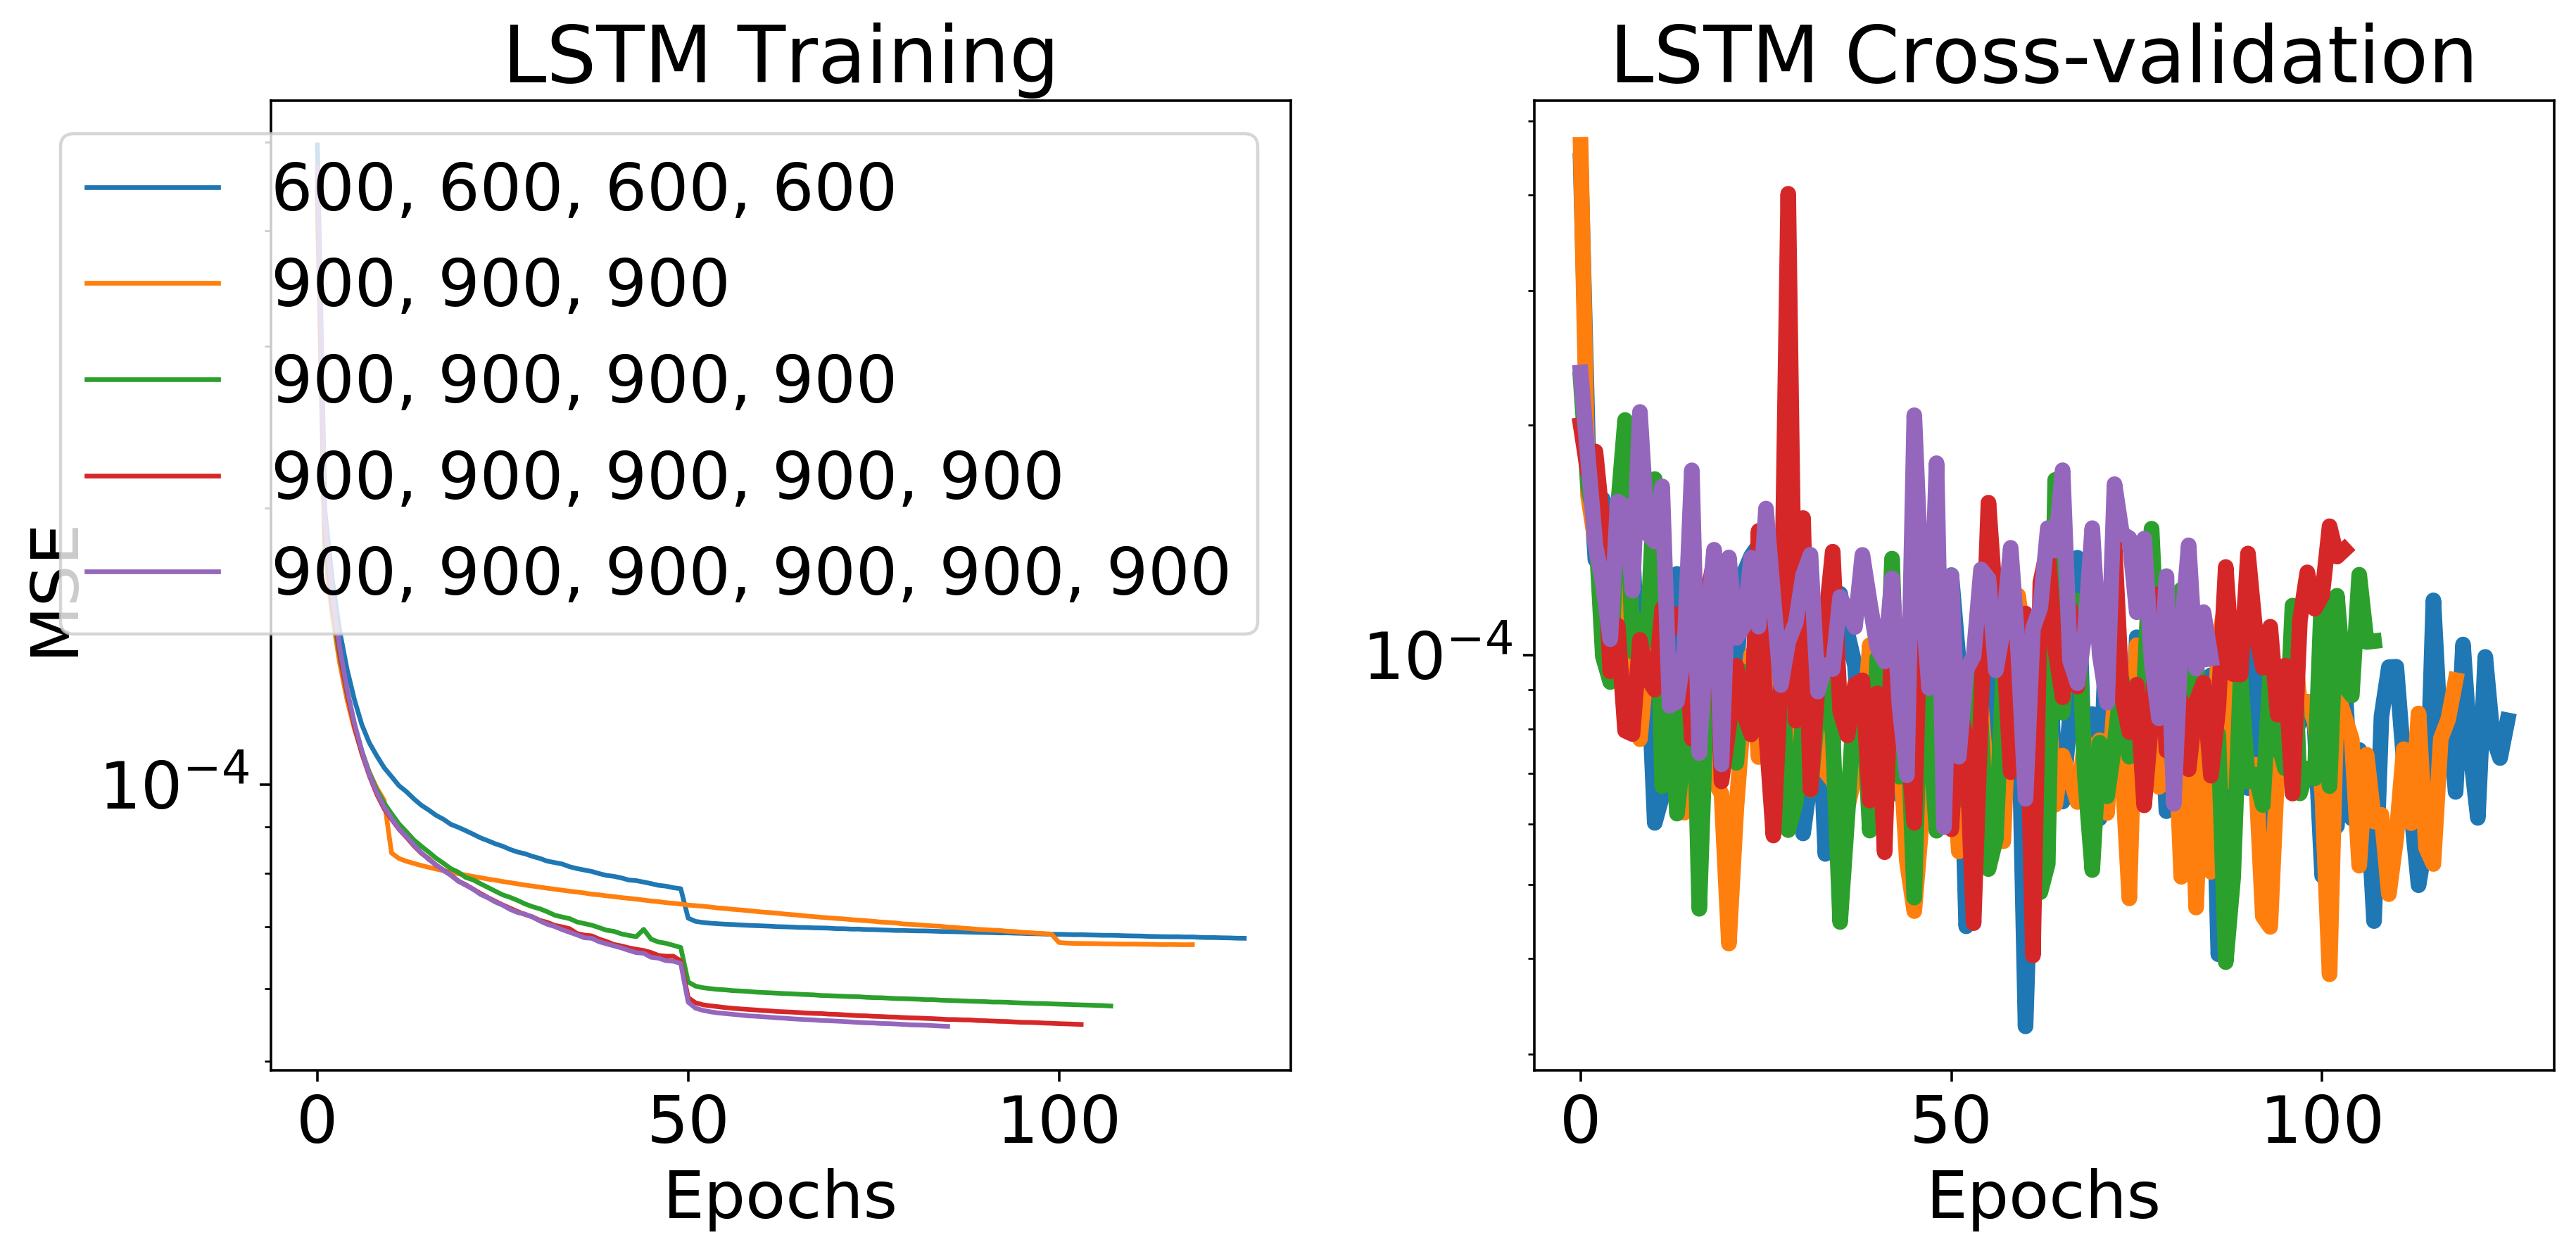

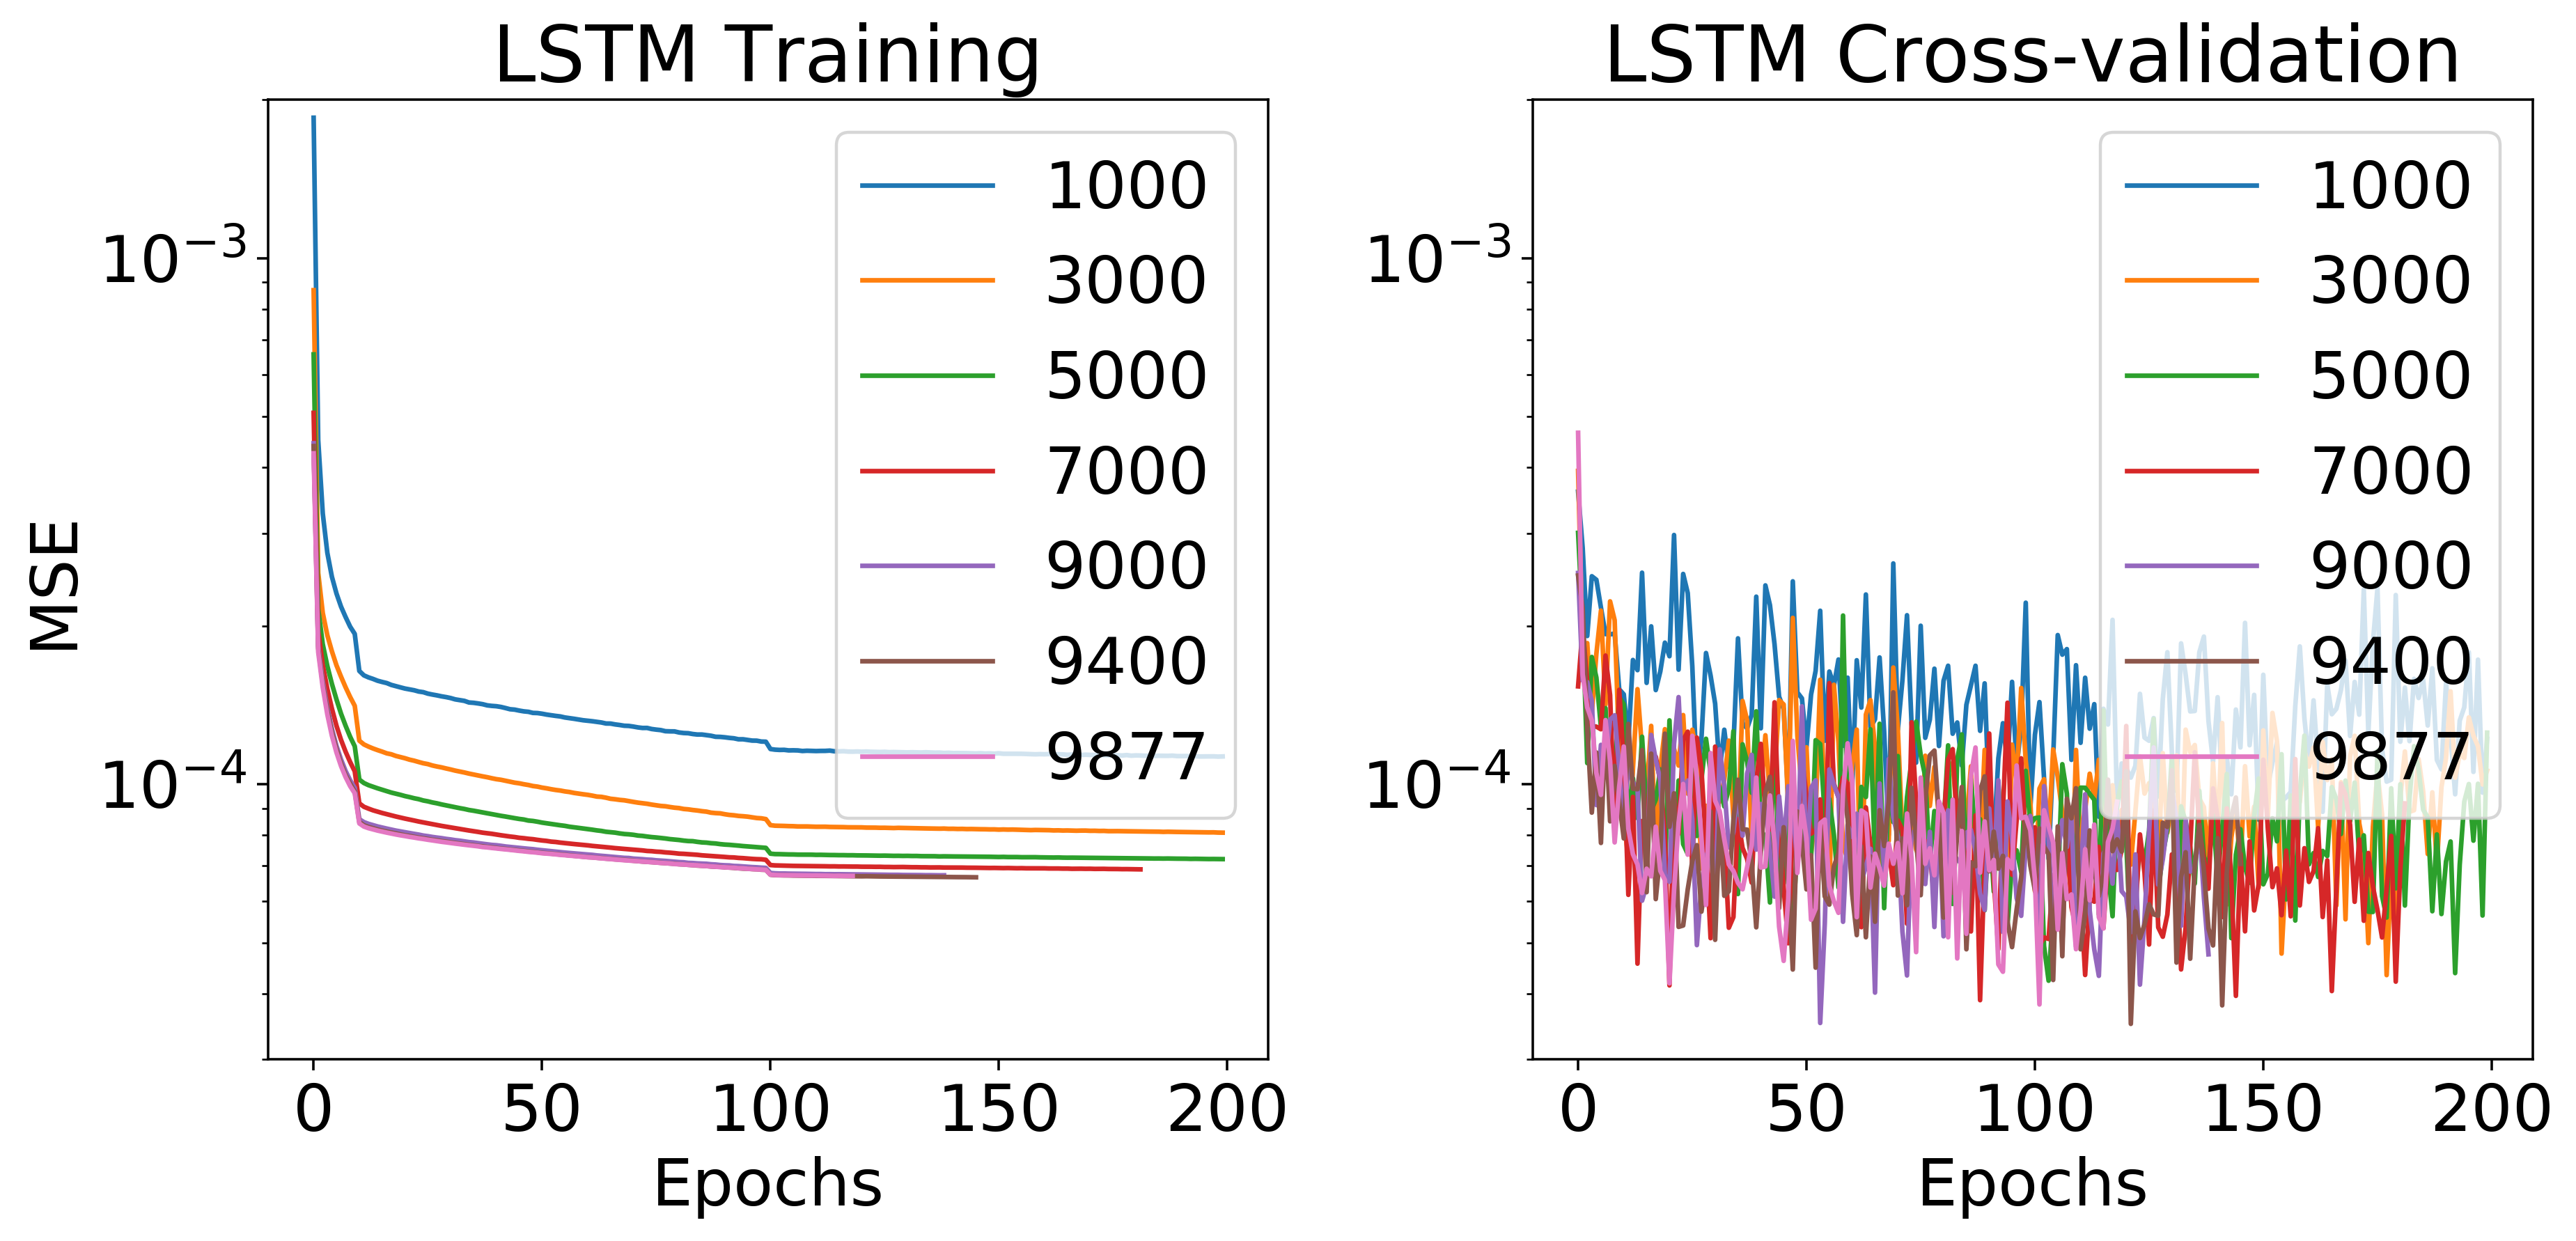

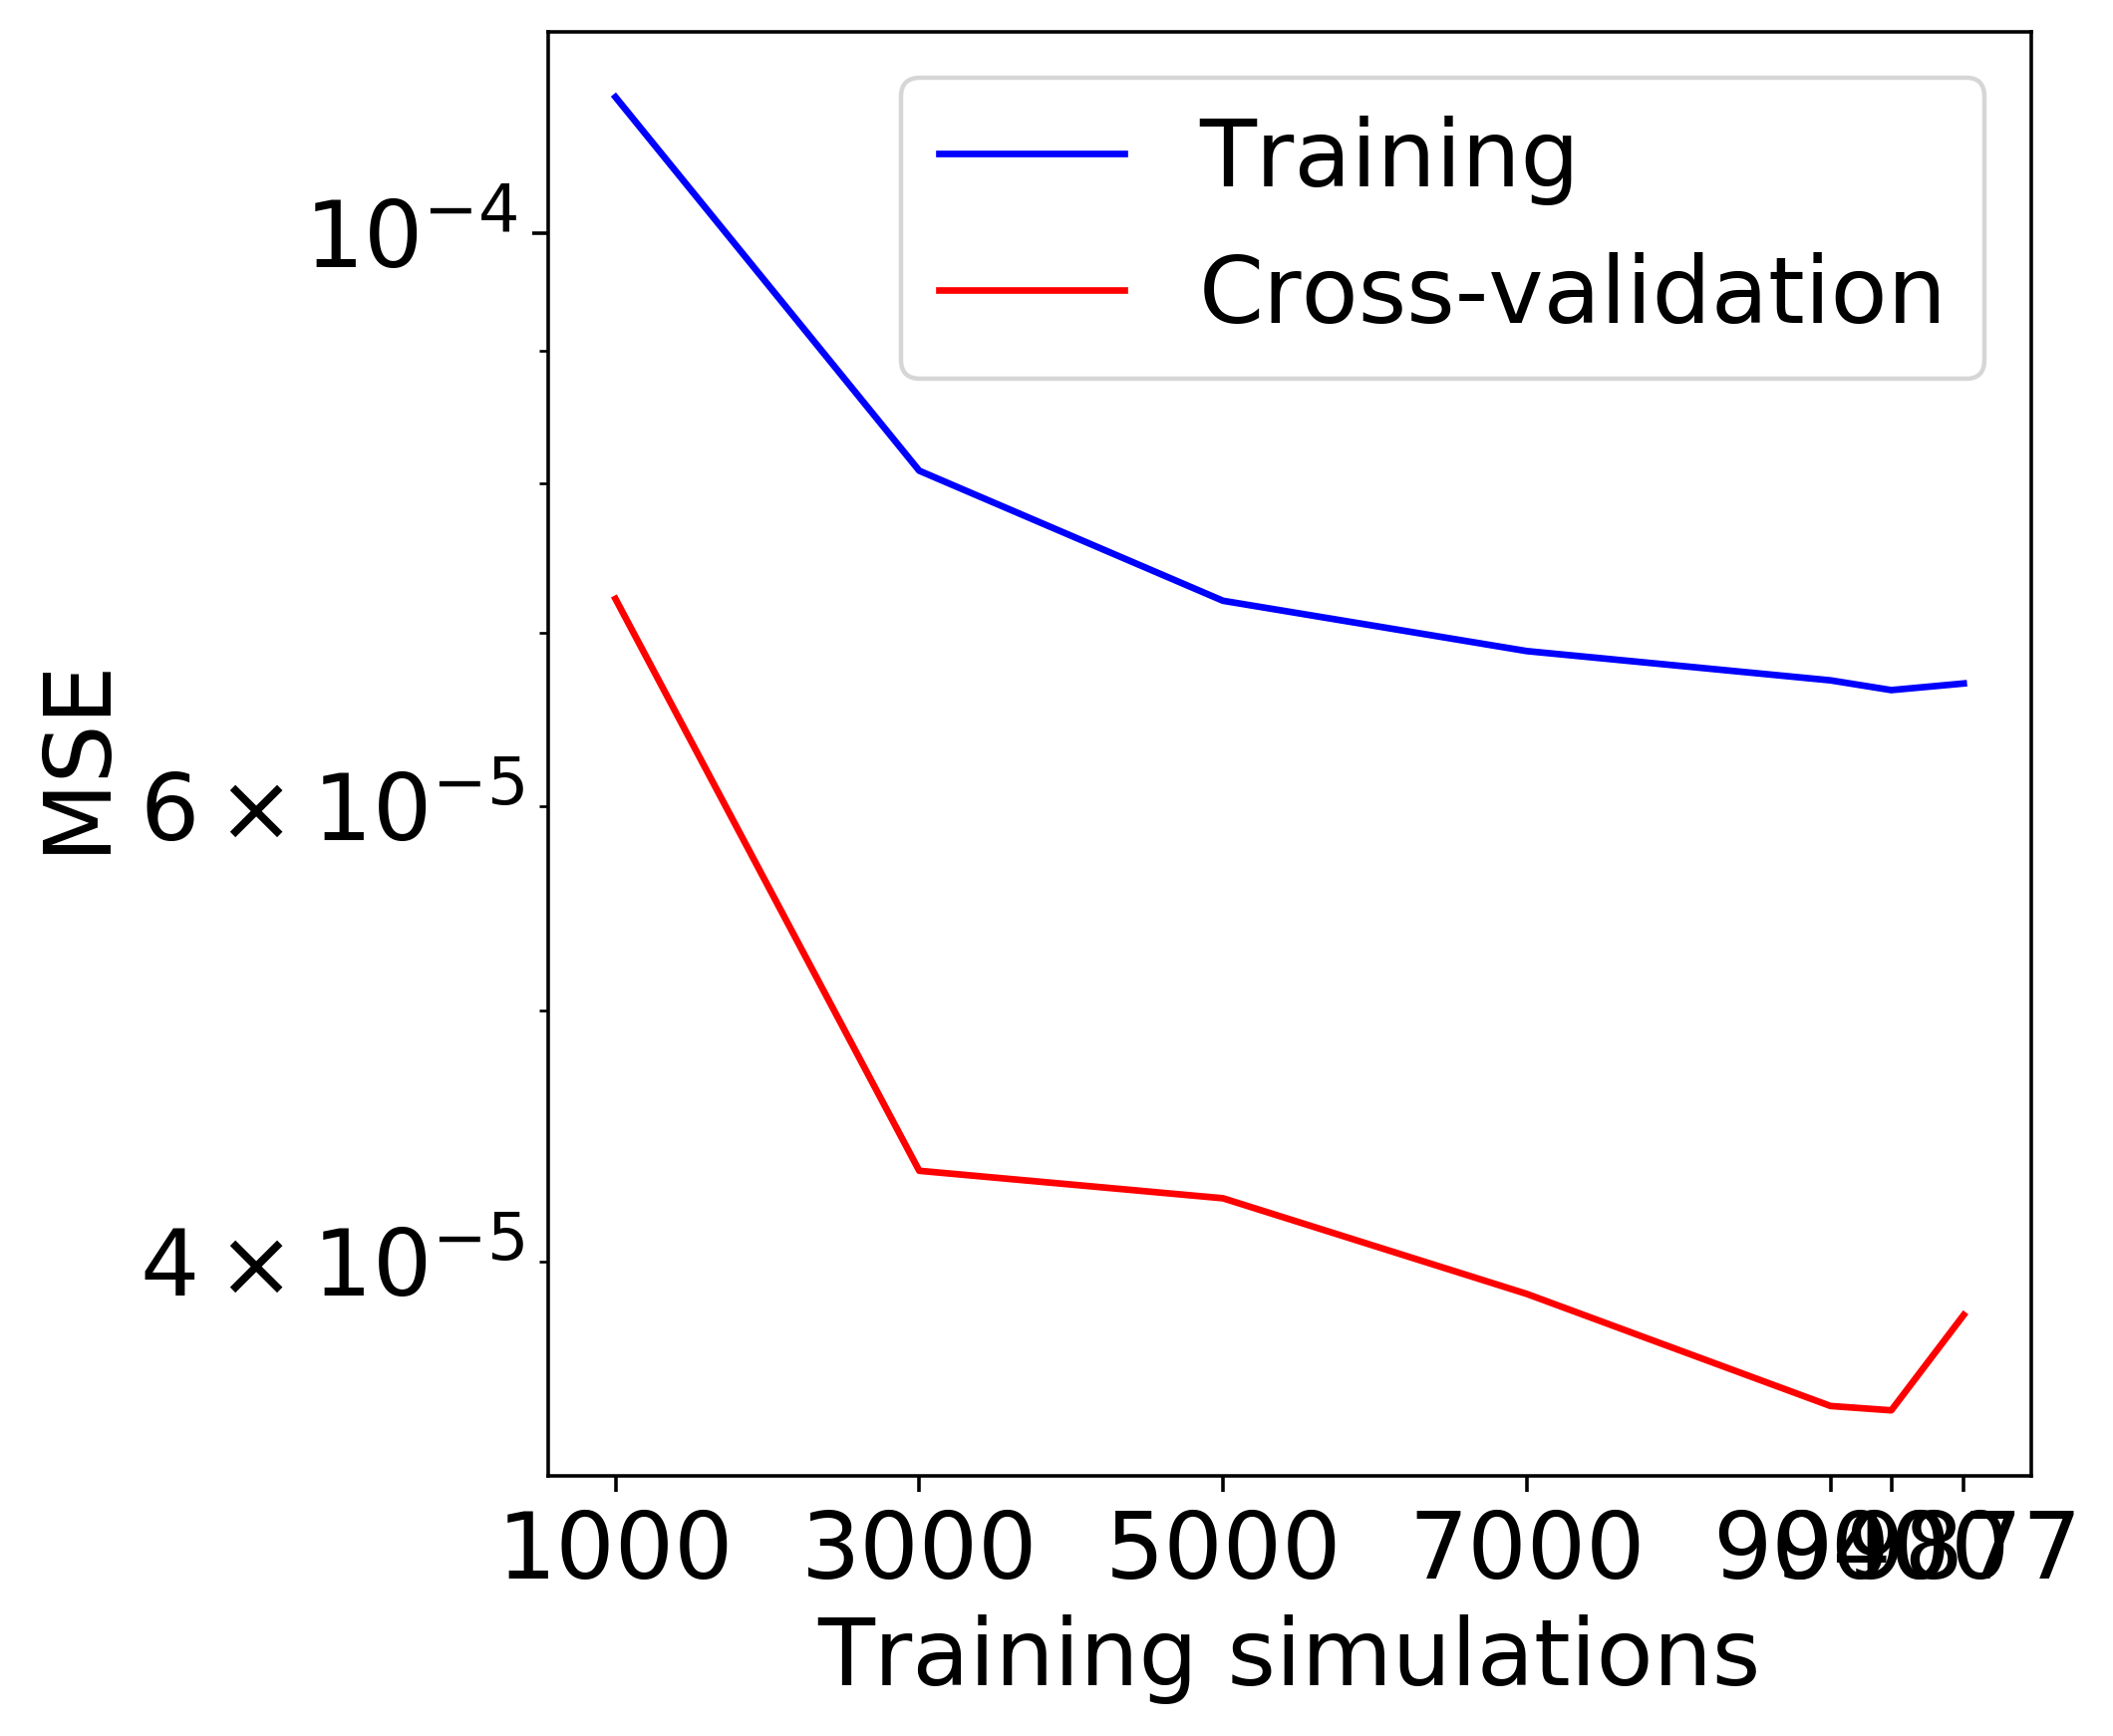

()
[[900, 900, 900, 900], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


NameError: name 'RegressionLSTM' is not defined

In [3]:
runCell = True

if runCell:
    ## NN parameters
    nnDict = {}
    counter = 0

    nnList = ['[[600, 600, 600, 600], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial0_custAct',
              #'[[900, 900, 900], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial1',
              '[[900, 900, 900], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_wtime_trial0',
              '[[900, 900, 900, 900], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial0',
              '[[900, 900, 900, 900, 900], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial0',
              '[[900, 900, 900, 900, 900, 900], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial0',
             ]

    plotLoss = True
    if plotLoss:
        loss = {}
        loss_cv = {}    

        for i, nn in enumerate(nnList):
            f = open(pathSave + 'TrainedNetworks/LSTM/' + nn + '.txt', 'r')
            lines = f.readlines()   
            l = []
            l_cv = []
            for _l in lines[1:]:
                l.append(float(_l.split(',')[1]))
                l_cv.append(float(_l.split(',')[2]))

            loss[str(i)] = l
            loss_cv[str(i)] = l_cv
        
        fig = plt.figure(figsize=(12,6), dpi=320)
        ax = fig.add_subplot(1,2,1) 
        axc = fig.add_subplot(1,2,2) 
        colors = ['r', 'b', 'm', 'y', 'k']
        for i in range(len(nnList)):
            #ynew = interpolate.interp1d(np.arange(0,len(loss_cv[str(i)])), loss_cv[str(i)],kind="cubic")
            label=nnList[i].split("],")[0][2:]
            ax.plot(loss[str(i)], '-',label=label)
            #axc.plot(ynew(np.arange(50)), '--',label=nnList[i].split("],")[0][2:]+"_cv")
            axc.plot(loss_cv[str(i)], '-',label=label,linewidth=5)
        
        ax.set_yscale("log")
        ax.legend()
        #ax.set_ylim([2e-5,1e-3])
        #axc.set_ylim([2e-5,1e-3])
        axc.set_yscale("log")
        #axc.legend()
        #axc.set_ylim([3e-5,2e-3])
        ax.set_title("LSTM Training")
        axc.set_title("LSTM Cross-validation")
        ax.set_ylabel("MSE")
        ax.set_xlabel("Epochs")
        axc.set_xlabel("Epochs")
        plt.tight_layout()
        plt.show() 
        #fig.savefig(pathSave + "Results/Fig_LSTM_loss.pdf", bbox_inches='tight')

        
        ###############################################################################
        loss = {}
        loss_cv = {}
        simList = [1000,3000,5000,7000,9000,9400,9877]
        
        for i in range(len(simList)):
            for trial in range(1):
                nn = '[[900, 900, 900], [], []]_ae840_selu_wDrpt_20to1_' + str(simList[i]) + 'Sims_0p98tr_wtime_trial' + str(trial)
                f = open(pathSave + 'TrainedNetworks/LSTM/' + nn + '.txt', 'r')
                lines = f.readlines()   
                l = []
                l_cv = []
                for _l in lines[1:]:
                    l.append(float(_l.split(',')[1]))
                    l_cv.append(float(_l.split(',')[2]))
                loss[str(i) + "_" + str(trial)] = l
                loss_cv[str(i) + "_" + str(trial)] = l_cv

        for i in range(len(simList)):
            loss[str(i) + "_mean"] = np.min(loss[str(i) + "_0"])
            loss_cv[str(i) + "_mean"] = np.min(loss_cv[str(i) + "_0"])
                
        fig = plt.figure(figsize=(12,6), dpi=320)
        ax = fig.add_subplot(1,2,1) 
        axc = fig.add_subplot(1,2,2) 
        #colors = ['r', 'b', 'm', 'y', 'k', 'g']
        for i in range(len(simList)):
            #ynew = interpolate.interp1d(np.arange(0,len(loss_cv[str(i)])), loss_cv[str(i)])
            ax.plot(loss[str(i) + "_0"], label=simList[i])
            #axc.plot(ynew(np.arange(0,20)), colors[i]+'--',label=nnList[i].split("],")[0][2:]+"_cv")
            axc.plot(loss_cv[str(i) + "_0"], label=simList[i])
        ax.set_yscale("log")
        ax.legend()
        ax.set_ylim([3e-5,2e-3])
        axc.set_yscale("log")
        axc.legend()
        axc.set_ylim([3e-5,2e-3])
        ax.set_title("LSTM Training")
        axc.set_title("LSTM Cross-validation")
        ax.set_ylabel("MSE")
        ax.set_xlabel("Epochs")
        axc.set_xlabel("Epochs")
        plt.tight_layout()
        plt.show()     
        
        fig = plt.figure(figsize=(6,6), dpi=320)
        ax = fig.add_subplot(1,1,1) 
        minLoss = []
        minLoss_cv = []
        for i in range(len(simList)):
            minLoss.append(loss[str(i) + "_mean"])
            minLoss_cv.append(loss_cv[str(i) + "_mean"])
        ax.plot(simList,minLoss,'b-',label="Training")
        ax.plot(simList,minLoss_cv,'r-',label="Cross-validation")
        ax.set_yscale("log")
        ax.set_xticks(simList)
        ax.set_xticklabels(simList)
        ax.set_xlabel("Training simulations")
        ax.set_ylabel("MSE")
        #ax.get_xticklabels()[-1].set_horizontalalignment('left')
        #ax.get_xticklabels()[4].set_horizontalalignment('right')
        #ax.get_xticklabels()[-2].set_horizontalalignment('left')
        #ax.get_xticklabels()[-4].set_horizontalalignment('left')
        #ax.get_xticklabels()[-2].set_verticalalignment('top')
        #ax.get_xticklabels()[-4].set_verticalalignment('top')
        #ax.xaxis.get_major_ticks()[5].set_pad(15)
        #ax.xaxis.get_major_ticks()[6].set_pad(30)
        #ax.xaxis.get_major_ticks()[7].set_pad(45)
        #ax.xaxis.get_major_ticks()[8].set_pad(60)
        
        ax.legend()
        plt.show()
        
    class createData():
        pass
    data = createData()

    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_96sims_1channel_ae840_x_test_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        data.x_test = load(myFile)
        
    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_[12000]sims_1channel_ae840_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)
    
    data.x = Dict_processed_data['x'] 
    data.y = Dict_processed_data['y'] 
    data.yMin = Dict_processed_data['postEncodedOMin'] 
    data.yMax = Dict_processed_data['postEncodedOMax']
    data.xMin = Dict_processed_data['paraMin'] 
    data.xMax = Dict_processed_data['paraMax']
    
    x_ = data.x
    y_ = data.y
    min_radius = x_[0]
    triang = tri.Triangulation(x_, y_)
    print(np.asarray(triang).shape)
                
    def runArchitecture(nn):      
        print(nn)
        R1 = RegressionLSTM(data, pathSave)
        R1.LSTM_predict(nn, 5, 0.00001)
        #R1.LSTM_extract(nn)
        
    Parallel(n_jobs=1, verbose=10)(delayed(runArchitecture)(_nn) for _nn in nnList[2:])

In [ ]:
runCell = False

if runCell:
    vecInterest = np.linspace(0.4,1.2,32)
    vecInterestTemp = np.asarray(np.copy(vecInterest))
    vecInterest = np.asarray(vecInterest)
    vecInterest = np.interp(vecInterest, (vecInterest.min(), vecInterest.max()), (0, 1))

    figc, axc = plt.subplots(figsize=(5,0.2), dpi=320)
    gradient= np.sort(vecInterest)
    gradient = np.vstack((gradient, gradient))
    axc.imshow(gradient, aspect='auto', cmap=plt.get_cmap('inferno'))
    axc.set_yticklabels([])
    axc.set_yticks([])
    #ax.set_xscale('log')

    my_xticks = axc.get_xticks()
    axc.set_xticks([my_xticks[1], my_xticks[-2]])
    axc.set_xticklabels(['{:.1f}'.format(np.amin(vecInterestTemp)), '{:.1f}'.format(np.amax(vecInterestTemp))])
    axc.set_xlabel("Temperature$'$")

    vecInterest = np.linspace(-0.1,0.1,32)
    vecInterestTemp = np.asarray(np.copy(vecInterest))
    vecInterest = np.asarray(vecInterest)
    vecInterest = np.interp(vecInterest, (vecInterest.min(), vecInterest.max()), (0, 1))

    figc, axc = plt.subplots(figsize=(5,0.2), dpi=320)
    gradient= np.sort(vecInterest)
    gradient = np.vstack((gradient, gradient))
    axc.imshow(gradient, aspect='auto', cmap=plt.get_cmap('inferno'))
    axc.set_yticklabels([])
    axc.set_yticks([])
    #ax.set_xscale('log')

    my_xticks = axc.get_xticks()
    axc.set_xticks([my_xticks[1], my_xticks[-2]])
    axc.set_xticklabels(['{:.1f}'.format(np.amin(vecInterestTemp)), '{:.1f}'.format(np.amax(vecInterestTemp))])
    axc.set_xlabel("Absolute error")

In [ ]:
runCell = False

if runCell:
    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_96sims_1channel_ae840_x_test_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        x_test = load(myFile)

    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_107sims_1channel_ae840_x_cv_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        x_cv = load(myFile)

    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_9877sims_1channel_ae840_x_data_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        x_data = load(myFile)

    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_[12000]sims_1channel_ae840_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)

    pMin = Dict_processed_data['paraMin'] 
    pMax = Dict_processed_data['paraMax']

    print(pMin,pMax)
    rho_m  = 3500. 
    g     = 3.7 
    alpha_m = 2.5e-5
    T_delta = 2000. 
    D = 1700e+3         
    k_diffusive = 1e-6 
    R = 8.314   

    plotParas = [r"$\log(\eta_{ref})$ [Pa s]", r"$E$ [J mol$^{-1}$]", r"$V$ [m$^3$ mol$^{-1}$]", 
                                 "$\Lambda$", "$T_{ini}$ [K]"]

    def format_func(_val, tick_number):
        f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
        _g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
        fmt = mticker.FuncFormatter(_g)
        return "{}".format(fmt(_val))

    def dimensionalize(_val,_ind):
        _min = pMin[_ind+3]
        _max = pMax[_ind+3]
        _val = _val*(_max-_min) + _min

        if _ind==0:
            _val = np.log10(rho_m * g * alpha_m * T_delta * np.power(D,3.)/(np.power(10.,_val) * k_diffusive))
        if _ind==1:
            _val = _val*(R * T_delta)
        if _ind==2:
            _val = _val*(R * T_delta) /(rho_m * g * D)
        if _ind==4:
            _val = _val*2000 + 250    
        return _val

In [ ]:
runCell = False

if runCell:
    titleVec = ["Training data", "Cross-validation data", "Test data"]
    minMax = [[70,130],[0,5],[0,5]]

    def makePlot(X, numBins, count):
        figm = plt.figure(figsize=(14,11), dpi=320)
        pltcount = 1

        for ind_x in range(len(plotParas)):
            for ind_y in range(len(plotParas)):
                if ind_x < ind_y:
                    ax = figm.add_subplot(len(plotParas),len(plotParas),pltcount)
                    x = dimensionalize(X[:,0,0,ind_x+2,0],ind_x)
                    y = dimensionalize(X[:,0,0,ind_y+2,0],ind_y)

                    ax.hist2d(x,y,bins=numBins,vmin=minMax[count][0],vmax=minMax[count][1],cmap="inferno")  #,norm=matplotlib.colors.LogNorm(),v
                    #ax.plot(x,y,'b.')
                    ax.set_xlabel(plotParas[ind_x])
                    ax.set_ylabel(plotParas[ind_y])
                    setTicks = True
                    if setTicks:
                        if ind_x==0:
                            ax.set_xticks([19,20,21,22])
                        if ind_y==0:
                            ax.set_yticks([19,20,21,22])
                        if ind_x==1:
                            ax.set_xticks([1e+5,3e+5,5e+5])
                            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
                        if ind_y==1:
                            ax.set_yticks([1e+5,3e+5,5e+5])
                            ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
                        if ind_x==2:
                            ax.set_xticks([4e-6, 7e-6, 10e-6])
                            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
                        if ind_y==2:
                            ax.set_yticks([4e-6, 7e-6, 10e-6])
                            ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
                        if ind_x==3:
                            ax.set_xticks([1,10,20,30,40,50])
                        if ind_y==3:
                            ax.set_yticks([1,10,20,30,40,50])
                        if ind_x==4:
                            ax.set_xticks([1600,1650,1700,1750,1800])
                        if ind_y==4:
                            ax.set_yticks([1600,1650,1700,1750,1800])

                        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                         ax.get_xticklabels() + ax.get_yticklabels()):
                            item.set_fontsize(15)
                pltcount += 1

        plt.tight_layout(w_pad=0.1,h_pad=0.1)

        vecInterest = np.linspace(minMax[count][0],minMax[count][1],10)
        vecInterestTemp = np.asarray(np.copy(vecInterest))
        vecInterest = np.asarray(vecInterest)
        vecInterest = np.interp(vecInterest, (vecInterest.min(), vecInterest.max()), (0, 1))

        figc, axc = plt.subplots(figsize=(6,0.2), dpi=320)
        gradient= np.sort(vecInterest)
        gradient = np.vstack((gradient, gradient))
        axc.imshow(gradient, aspect='auto', cmap=plt.get_cmap('inferno'))
        axc.set_yticklabels([])
        axc.set_yticks([])
        #ax.set_xscale('log')

        my_xticks = axc.get_xticks()
        axc.set_xticks([my_xticks[1], my_xticks[-2]])
        axc.set_xticklabels(['{:.0f}'.format(np.amin(vecInterestTemp)), '{:.0f}'.format(np.amax(vecInterestTemp))])
        axc.set_xlabel(titleVec[count])

        plt.show()

    makePlot(x_data,10,0)
    makePlot(x_cv,10,1)
    makePlot(x_test,10,2)

99.17715851330696
21.560541557996277
21.560541557996277
21.560541557996277
21.560541557996277
155181.30884
155181.30884
155181.30884
4.356316962071315e-06
4.356316962071315e-06
15.27563
(array([], dtype=int64),)


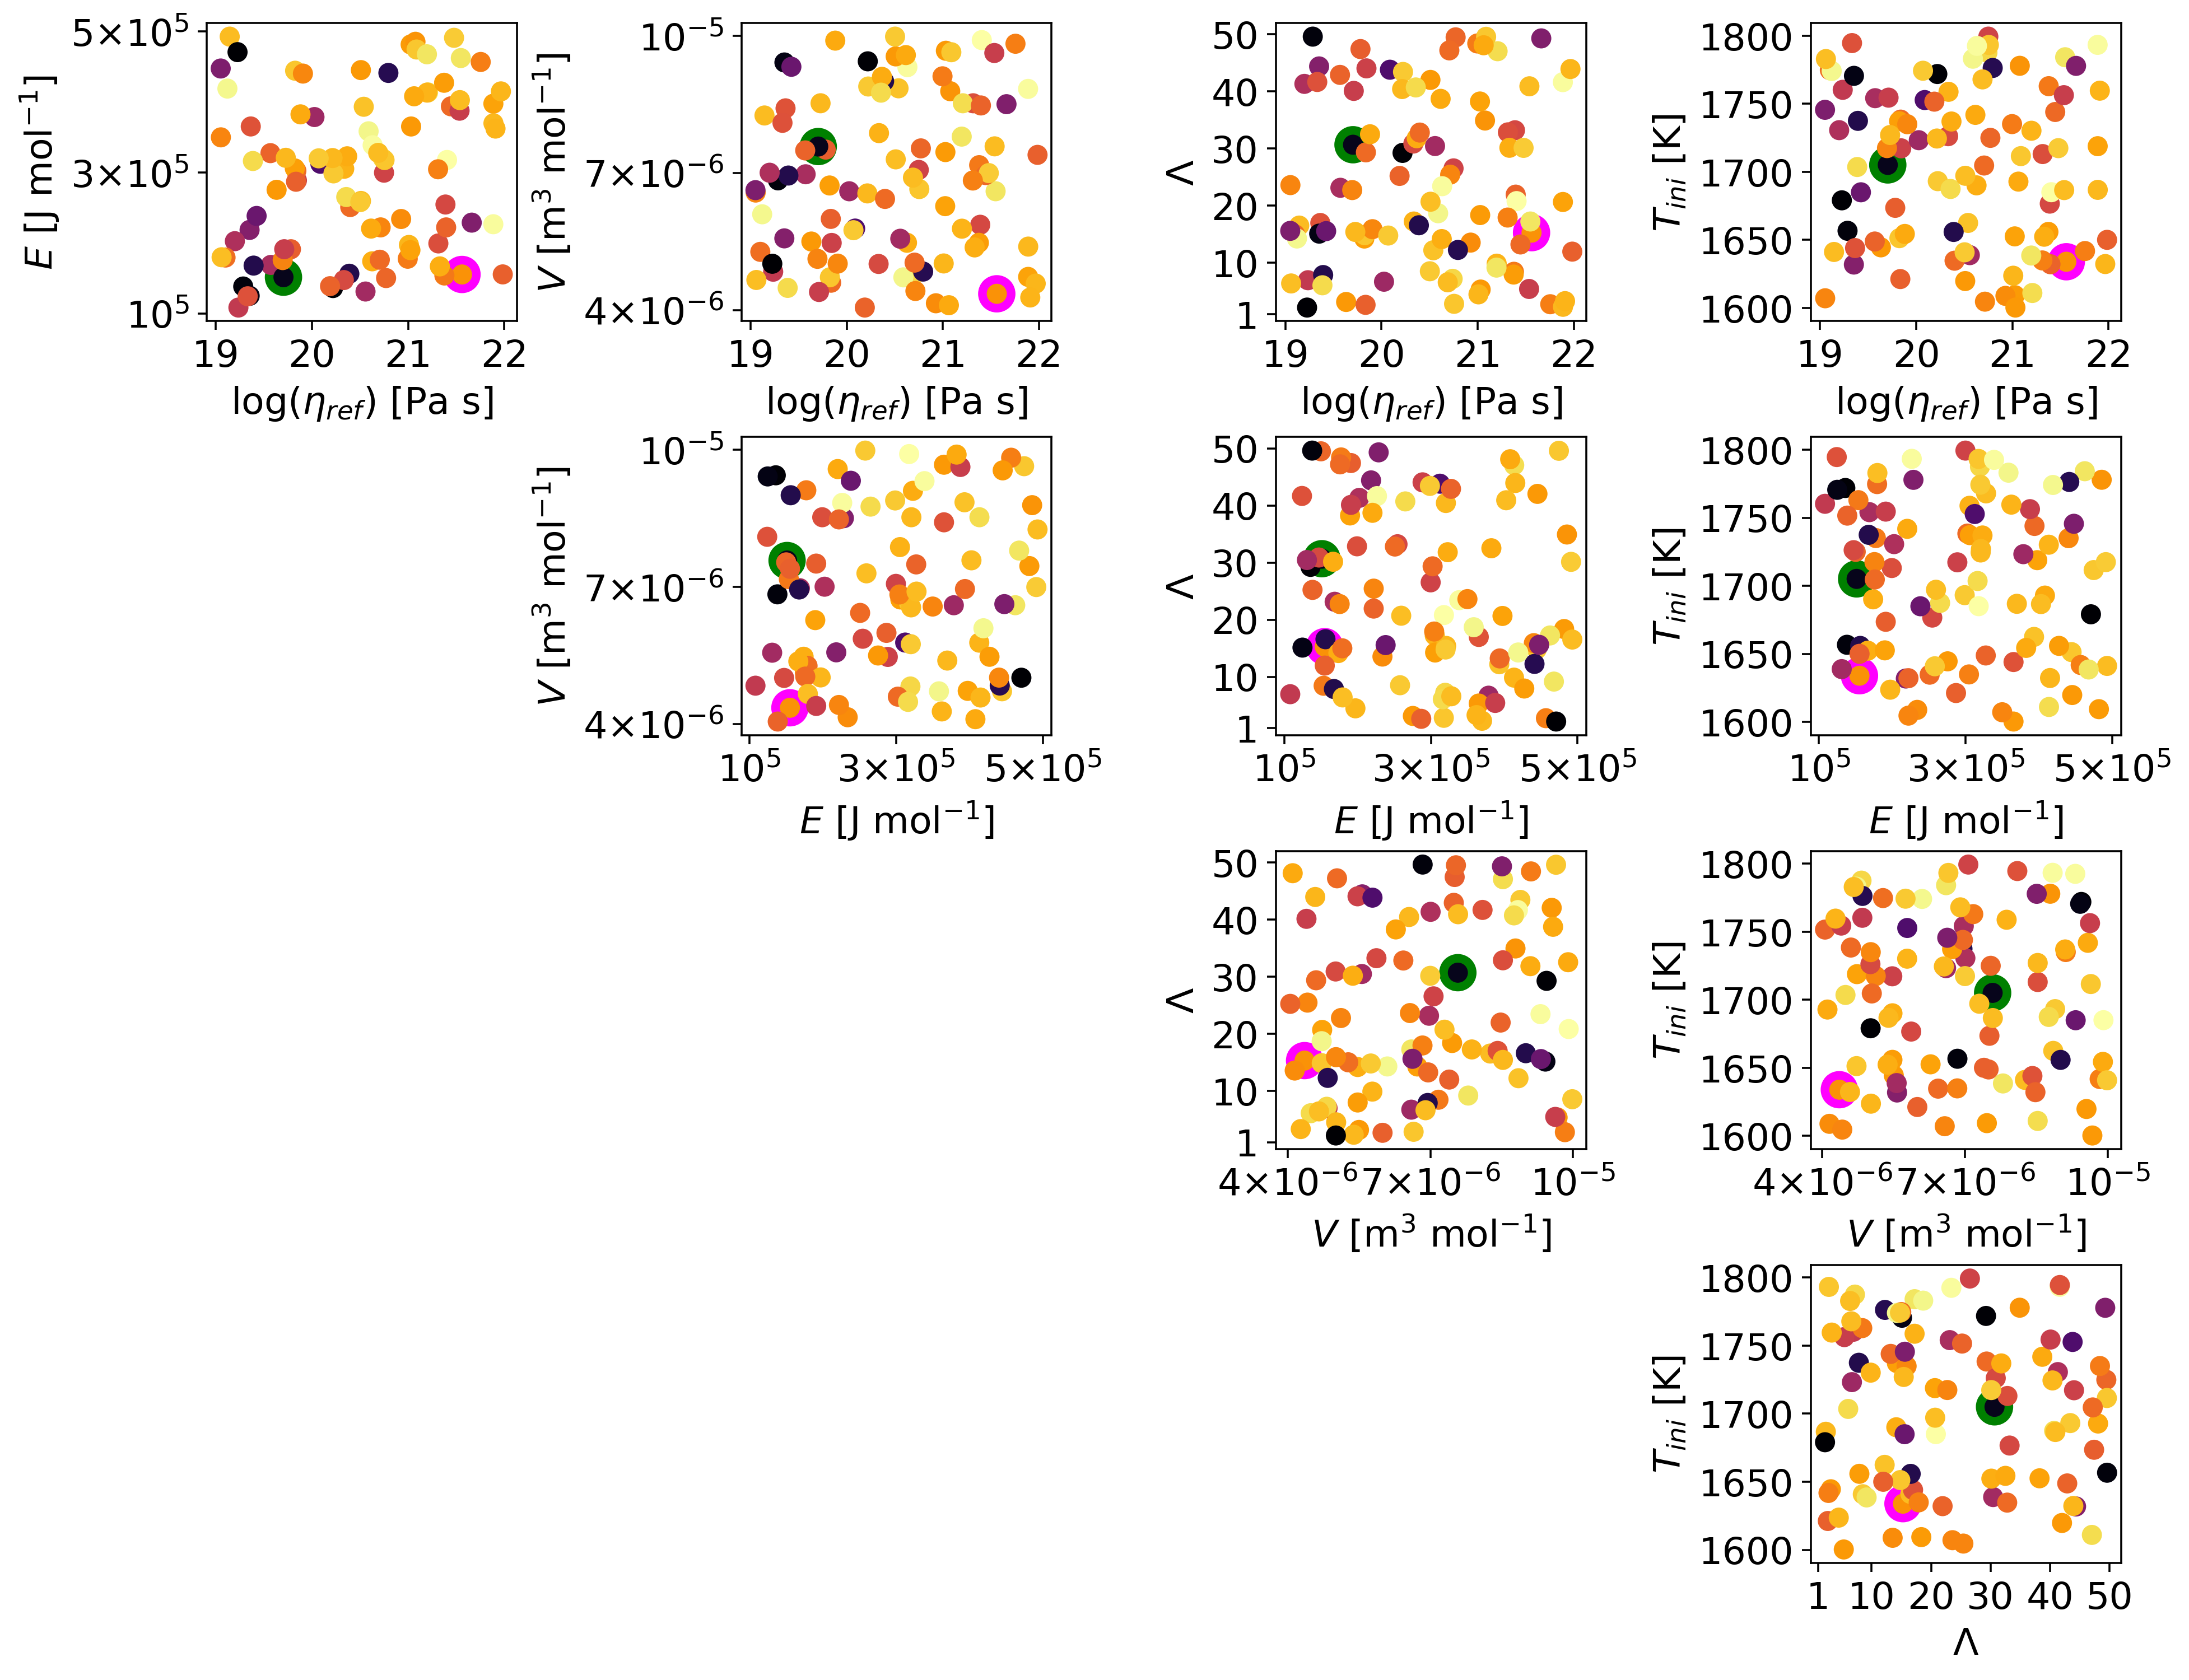

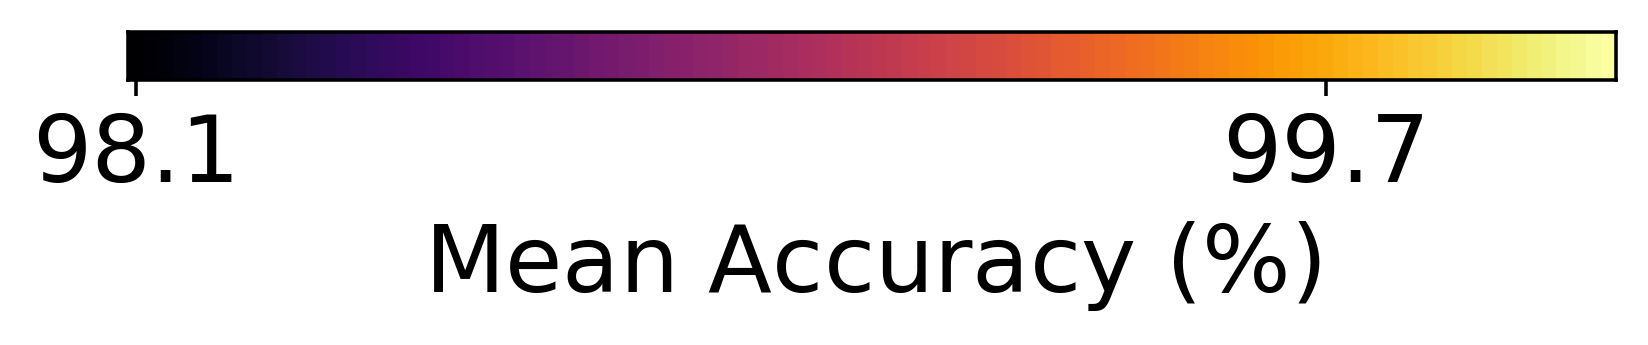

In [23]:
runCell = True

if runCell:
    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_96sims_1channel_ae840_x_test_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        x_test = load(myFile)

    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_[12000]sims_1channel_ae840_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)

    dictToOpen = "Results/Error_lg_[[600, 600, 600, 600], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial0_custAct_96Sims.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Error_lg = load(myFile)

    pMin = Dict_processed_data['paraMin'] 
    pMax = Dict_processed_data['paraMax']

    rho_m  = 3500. 
    g     = 3.7 
    alpha_m = 2.5e-5
    T_delta = 2000. 
    D = 1700e+3         
    k_diffusive = 1e-6 
    R = 8.314   

    plotParas = [r"$\log(\eta_{ref})$ [Pa s]", r"$E$ [J mol$^{-1}$]", r"$V$ [m$^3$ mol$^{-1}$]", 
                                 "$\Lambda$", "$T_{ini}$ [K]"]

    errorVec = []
    counter = 0
    for sInd in range(x_test.shape[0]):
        errorTemp = []
        for tInd in range(1,x_test.shape[1]):
            if x_test[sInd,tInd,0,0,0] > 0:
                errorTemp.append(Error_lg[counter])
                counter += 1
        errorVec.append(np.mean(np.asarray(errorTemp)))
    #errorVec[37] = 99.21390371904141
    
    print(np.mean(errorVec))

    def format_func(_val, tick_number):
        f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
        _g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
        fmt = mticker.FuncFormatter(_g)
        return "{}".format(fmt(_val))

    def dimensionalize(_val,_ind):
        _min = pMin[_ind+3]
        _max = pMax[_ind+3]
        _val = _val*(_max-_min) + _min

        if _ind==0:
            _val = np.log10(rho_m * g * alpha_m * T_delta * np.power(D,3.)/(np.power(10.,_val) * k_diffusive))
        if _ind==1:
            _val = _val*(R * T_delta)
        if _ind==2:
            _val = _val*(R * T_delta) /(rho_m * g * D)
        if _ind==4:
            _val = _val*2000 + 250  
        return _val

    figm = plt.figure(figsize=(14,11), dpi=320)
    pltcount = 1

    for ind_x in range(len(plotParas)):
        for ind_y in range(len(plotParas)):
            if ind_x < ind_y:
                ax = figm.add_subplot(len(plotParas),len(plotParas),pltcount)
                x = dimensionalize(x_test[:,0,0,ind_x+2,0],ind_x)
                y = dimensionalize(x_test[:,0,0,ind_y+2,0],ind_y)

                print(x[0])

                ax.scatter(dimensionalize(x_test[0,0,0,ind_x+2,0],ind_x), dimensionalize(x_test[0,0,0,ind_y+2,0],ind_y), s=100, marker = "o", facecolor="None", linewidth=5, edgecolors='magenta')
                ax.scatter(dimensionalize(x_test[12,0,0,ind_x+2,0],ind_x), dimensionalize(x_test[12,0,0,ind_y+2,0],ind_y), s=100, marker = "o", facecolor="None", linewidth=5, edgecolors='green')
                ax.scatter(x, y, c=errorVec, s=50, cmap="inferno")
                ax.plot(x, y, color='none')
                ax.relim()
                ax.autoscale_view()
                ax.set_xlabel(plotParas[ind_x])
                ax.set_ylabel(plotParas[ind_y])
                setTicks = True
                if setTicks:
                    if ind_x==0:
                        ax.set_xticks([19,20,21,22])
                    if ind_y==0:
                        ax.set_yticks([19,20,21,22])
                    if ind_x==1:
                        ax.set_xticks([1e+5,3e+5,5e+5])
                        ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
                    if ind_y==1:
                        ax.set_yticks([1e+5,3e+5,5e+5])
                        ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
                    if ind_x==2:
                        ax.set_xticks([4e-6, 7e-6, 10e-6])
                        ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
                    if ind_y==2:
                        ax.set_yticks([4e-6, 7e-6, 10e-6])
                        ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
                    if ind_x==3:
                        ax.set_xticks([1,10,20,30,40,50])
                    if ind_y==3:
                        ax.set_yticks([1,10,20,30,40,50])
                    if ind_x==4:
                        ax.set_xticks([1600,1650,1700,1750,1800])
                    if ind_y==4:
                        ax.set_yticks([1600,1650,1700,1750,1800])

                    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
                        item.set_fontsize(15)
            pltcount += 1
    plt.tight_layout(pad=0.1)
    #fig.savefig(pathSave + "Results/Fig_LSTM_all.pdf", bbox_inches='tight')

    vecInterest = np.linspace(np.min(errorVec),np.max(errorVec),100)
    vecInterestTemp = np.asarray(np.copy(vecInterest))
    vecInterest = np.asarray(vecInterest)
    vecInterest = np.interp(vecInterest, (vecInterest.min(), vecInterest.max()), (0, 1))

    figc, axc = plt.subplots(figsize=(6,0.2), dpi=320)
    gradient= np.sort(vecInterest)
    gradient = np.vstack((gradient, gradient))
    axc.imshow(gradient, aspect='auto', cmap=plt.get_cmap('inferno'))
    axc.set_yticklabels([])
    axc.set_yticks([])
    #ax.set_xscale('log')

    my_xticks = axc.get_xticks()
    axc.set_xticks([my_xticks[1], my_xticks[-2]])
    axc.set_xticklabels(['{:.1f}'.format(np.amin(vecInterestTemp)), '{:.1f}'.format(np.amax(vecInterestTemp))])
    axc.set_xlabel("Mean Accuracy ($\%$)")

    print(np.where(np.asarray(errorVec)<94))

    plt.show()

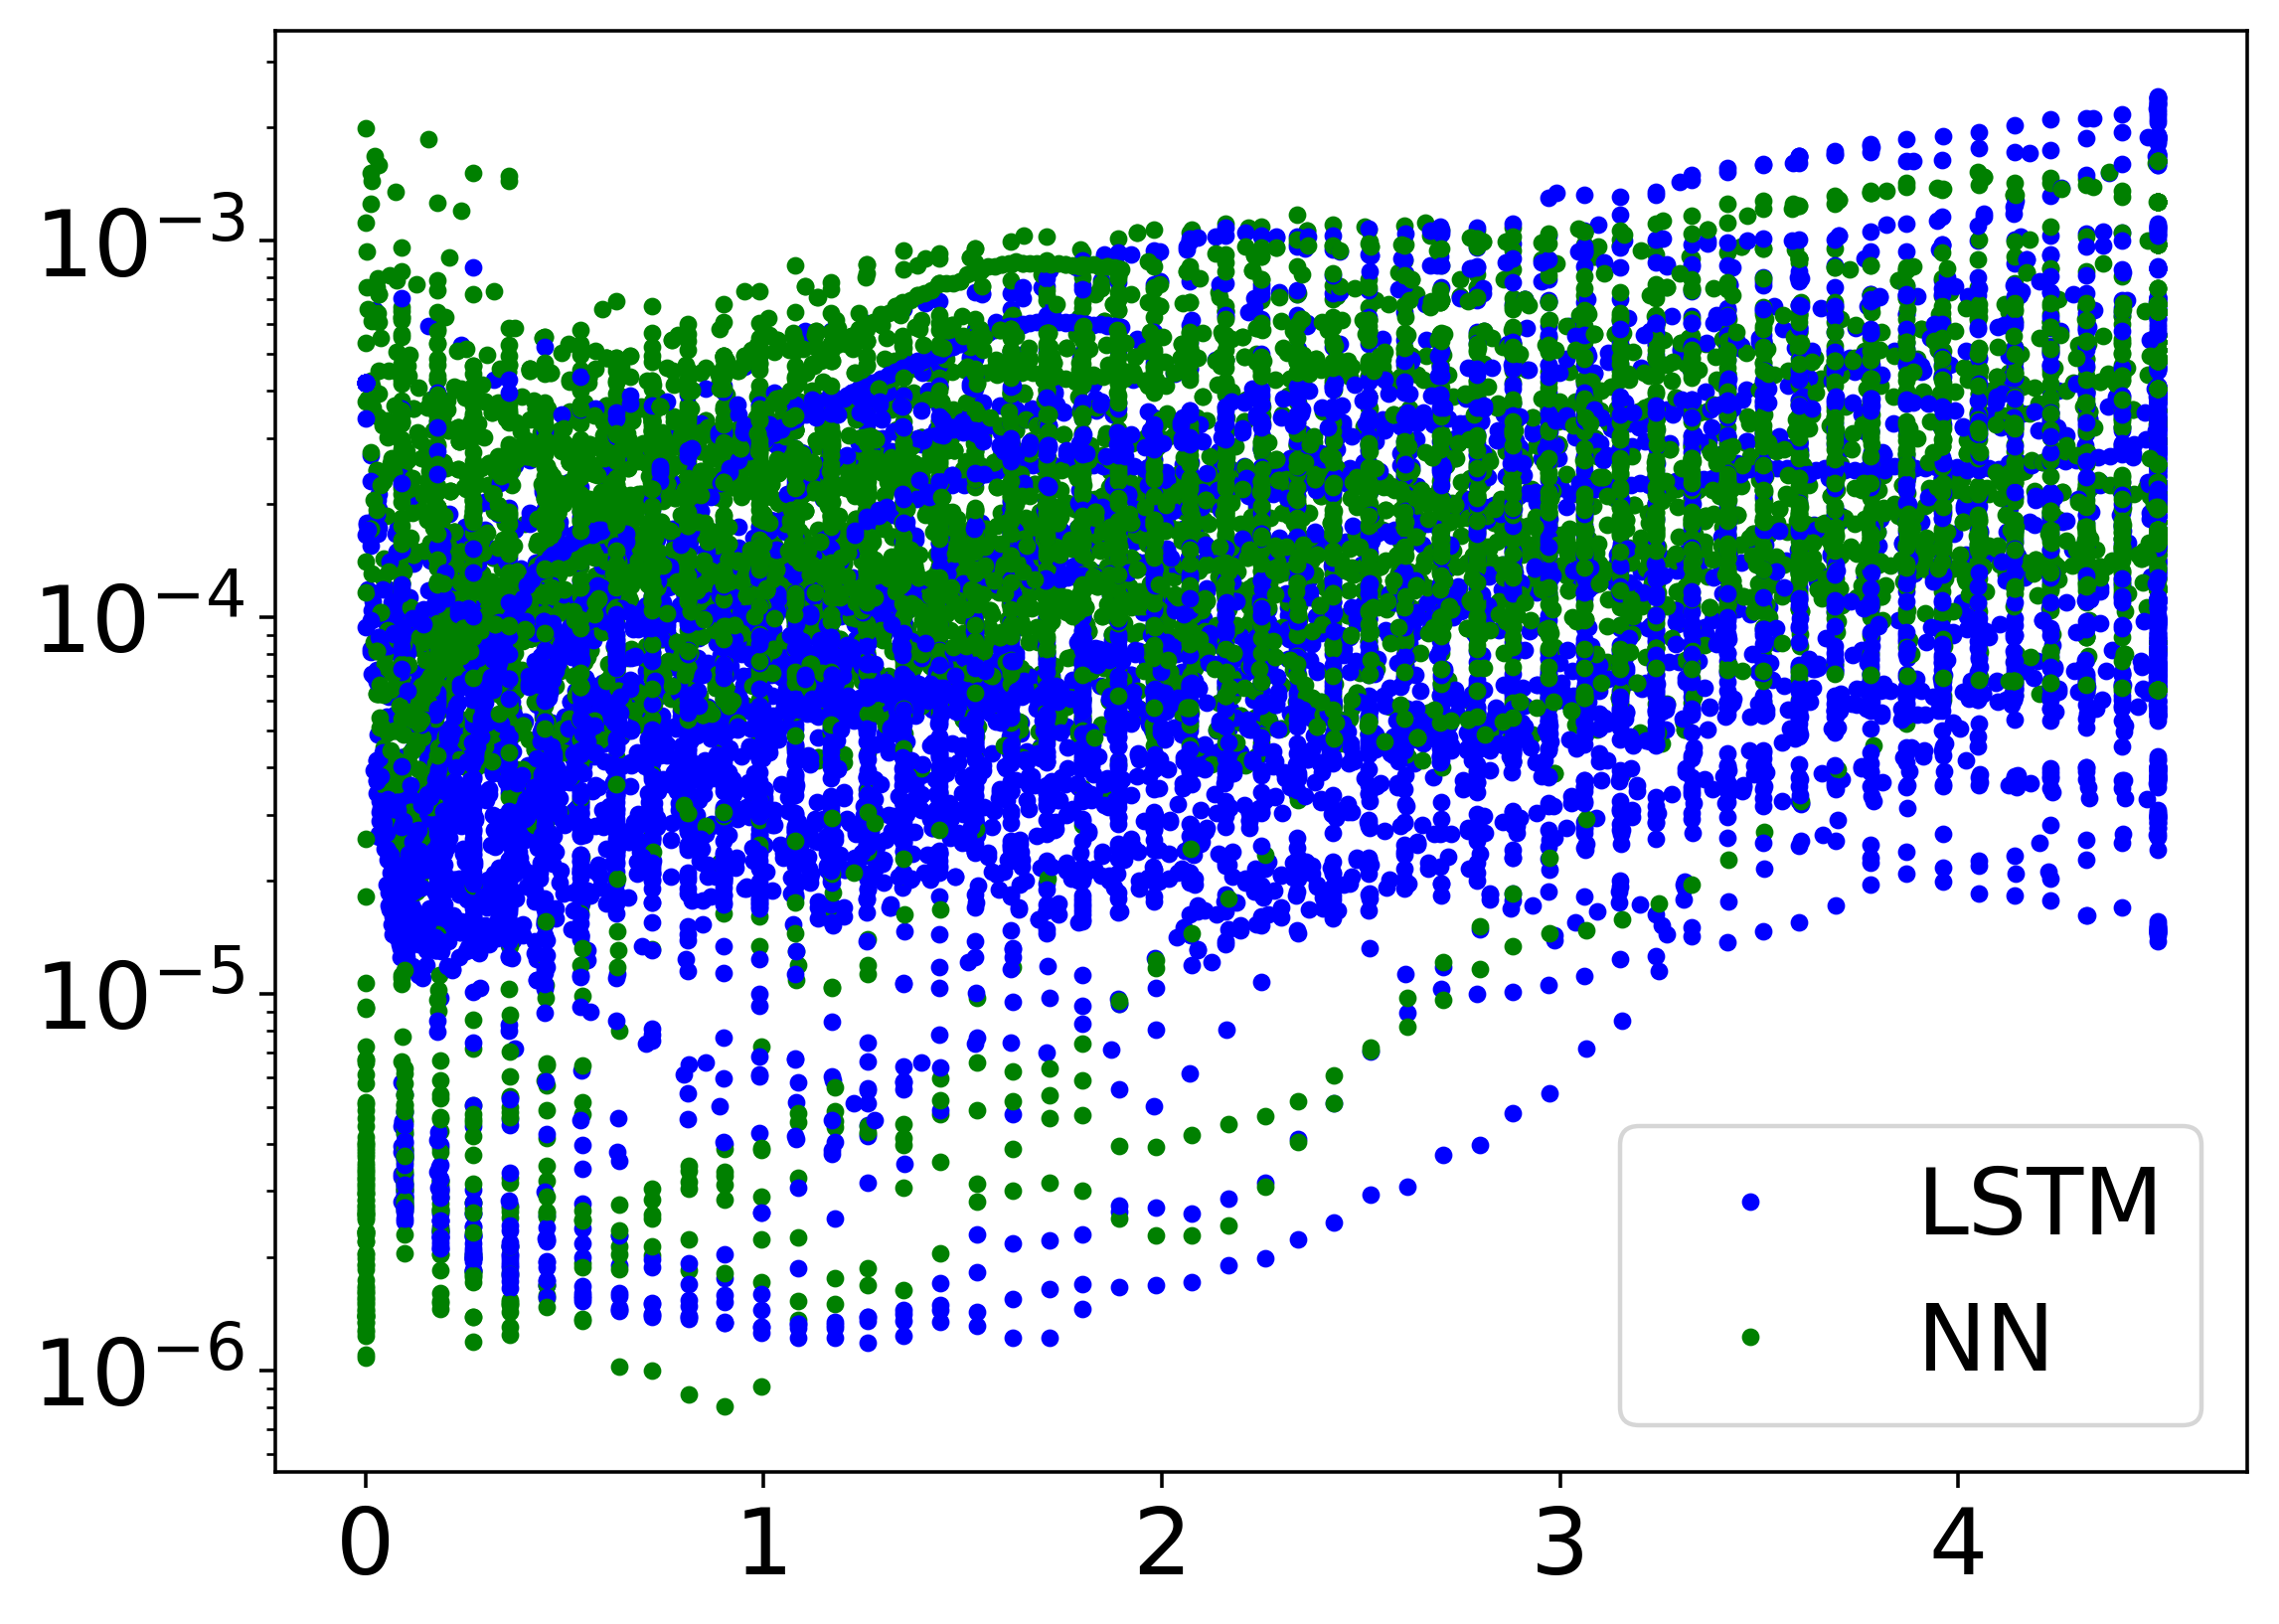

In [25]:
runCell = True

if runCell:
    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_96sims_1channel_ae840_x_test_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        x_test = load(myFile)

    dictToOpen = "Results/MSEError_lg_[[600, 600, 600, 600], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial0_custAct_96Sims.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Errorlg = load(myFile)    

    dictToOpen = "Results/MSEError_nc_96Sims_Compressed.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Errorng = load(myFile)

    dictToOpen = "processedDicts/Mars_new/ConvLSTM/T/Dict_processed_data_MarsNew_2D_ConvLSTM_T_[12000]sims_1channel_ae840_0p98tr_wt.txt" 
    with open(pathSave + dictToOpen, "rb") as myFile:
        Dict_processed_data = load(myFile)
        
    xMin = Dict_processed_data['paraMin'] 
    xMax = Dict_processed_data['paraMax']


    Error_lg = []
    Error_ng = []
    counter = 0
    for sInd in range(x_test.shape[0]):
        errorTemp0 = []
        errorTemp1 = []
        for tInd in range(x_test.shape[1]):
            if x_test[sInd,tInd,0,0,0] > 0:
                errorTemp0.append(Errorlg[counter])
                errorTemp1.append(Errorng[counter])
                counter += 1
        Error_lg.append(np.mean(np.asarray(errorTemp0)))
        Error_ng.append(np.mean(np.asarray(errorTemp1)))

    D = 1700e+3 
    k_diffusive = 1e-6    
    year_to_seconds = 365.25 * 24. * 3600.

    doBroken=False
    
    if doBroken:
        f, (ax, ax2) = plt.subplots(2, 1, figsize=(8,6), dpi=320, sharex=True)
        counter = 0
        for sInd in range(x_test.shape[0]):
            for tInd in range(x_test.shape[1]):
                if x_test[sInd,tInd,0,0,0] > 0:
                    time = (x_test[sInd,tInd,1,0,0]*(xMax[0]-xMin[0])+xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9)
                    ax2.plot(time,Errorlg[counter],'b.')
                    ax2.plot(time,Errorng[counter],'g.')
                    if np.mean(Errorlg[counter])>1e+2:
                        ax.plot(time,Errorlg[counter],'b.')
                        ax.plot(time,Errorng[counter],'g.')
                    counter += 1

        ax.legend(["LSTM", "NN"])
        # zoom-in / limit the view to different portions of the data
        ax.set_ylim(1e+2,1e+15)  # outliers only
        ax2.set_ylim(1e-7,1e-1)  # most of the data
        ax.set_yscale("log")
        ax2.set_yscale("log")

        ax.set_yticks([1e+3,1e+9,1e+15])

        # hide the spines between ax and ax2
        ax.spines['bottom'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax.xaxis.tick_top()
        ax.tick_params(labeltop=False)  # don't put tick labels at the top
        ax2.xaxis.tick_bottom()

        d = .015  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
        ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

        ax2.set_xlabel("Time [Gyr]")
        ax2.set_ylabel("MSE")

    else:
        f, ax = plt.subplots(1, 1, figsize=(8,6), dpi=320)
        counter = 0
        for sInd in range(x_test.shape[0]):
            for tInd in range(x_test.shape[1]):
                if x_test[sInd,tInd,0,0,0] > 0:
                    time = (x_test[sInd,tInd,1,0,0]*(xMax[0]-xMin[0])+xMin[0])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9)
                    ax.plot(time,Errorlg[counter],'b.')
                    ax.plot(time,Errorng[counter],'g.')
                    counter += 1

        ax.legend(["LSTM", "NN"])
        ax.set_yscale("log")
        ax2.set_xlabel("Time [Gyr]")
        ax2.set_ylabel("MSE")
    #f.savefig(pathSave + "Results/Fig_time_Error.pdf", bbox_inches='tight')
    plt.show()